Firstly, we will import the necessary libraries.

In [1]:

# General libraries
import numpy as np
import pandas as pd
import random
import time
import itertools

# Visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Geospatial visualization libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import geodatasets

# Scikit-learn libraries
from sklearn.cluster import (
    KMeans, MiniBatchKMeans, AgglomerativeClustering, MeanShift, HDBSCAN
)
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

# Configure default styles
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100


I will load the data from my repository. I think it's a better approach than using Google Drive.

In [2]:
def load_data(file_path: str) -> pd.DataFrame:

    url = "https://raw.githubusercontent.com/mtech00/EPAM_DS/refs/heads/main/data.%20module%205.%20Clustering/quake.csv"
    df = pd.read_csv(url)
    return df


df = load_data('quakes_data.csv')
print("Data loaded successfully!")
print("Data shape:", df.shape)
df.head()


Data loaded successfully!
Data shape: (2178, 4)


Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
2           57     41.85     142.78      5.8
3           67     29.19     141.15      6.2
4           30    -21.66     169.81      6.0

Here, we will take an overview of the data. Unlike other datasets, this one is significantly smaller and has considerably fewer distinct features. Additionally, there are no missing values.

In [3]:
def data_overview(df: pd.DataFrame):
    """
    Print basic info such as shape, columns, missing values and a quick data info summary.
    """
    print("Data Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nData Info:")
    df.info()

# Example usage:
data_overview(df)


Data Shape: (2178, 4)

Columns: ['Focal depth', 'Latitude', 'Longitude', 'Richter']

Missing Values:
Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


For the scalar values, I will check the minimum to ensure there is no faulty data. For example, the Richter scale cannot be negative, and focal depth cannot be negative either. Additionally, the Richter scale cannot exceed 10. For the coordinates, latitude must be between -90 and 90, and longitude must be between -180 and 180.

In [4]:
def descriptive_stats(df: pd.DataFrame):

    stats = df.describe()
    display(stats)


descriptive_stats(df)


Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

Here, we perform classical exploratory data analysis (EDA) to examine the distribution of the data:

Focal depth** is highly skewed and contains some outliers.  
The distribution shows multiple peaks, suggesting that earthquakes are more frequent in specific latitude ranges.  
There are notable occurrences along specific longitudes.  
The Richter scale is left-skewed and generally falls between 5.8 and 6.2.  

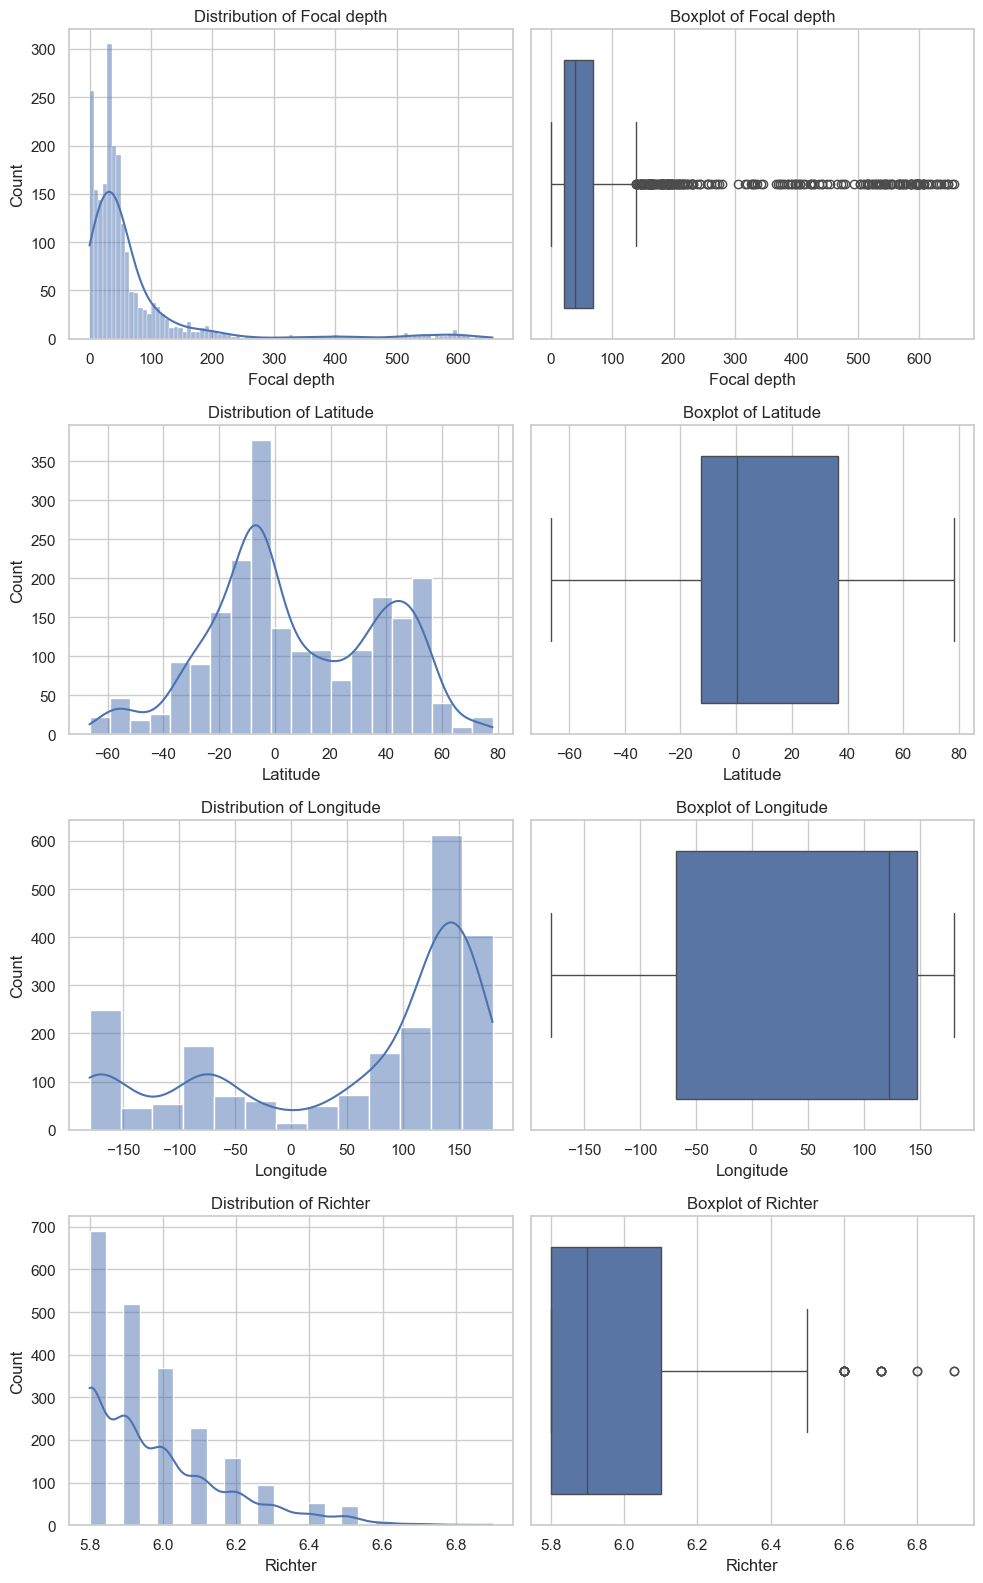

In [5]:
def univariate_analysis(df: pd.DataFrame, numeric_cols: list):

    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(10, 4*len(numeric_cols)))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
 
        sns.histplot(df[col], ax=axes[2*i], kde=True)
        axes[2*i].set_title(f"Distribution of {col}")

     
        sns.boxplot(x=df[col], ax=axes[2*i+1])
        axes[2*i+1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


numeric_columns = ['Focal depth', 'Latitude', 'Longitude', 'Richter']
univariate_analysis(df, numeric_columns)


Here, we conducted a multivariate analysis to understand the correlation between features:  

 Firstly, we created scatter plots to visually examine the potential correlations. As you can see, there was no significant correlation observed.  
 Afterward, we generated a heatmap, which confirmed that there is clearly no strong correlation between the features.  

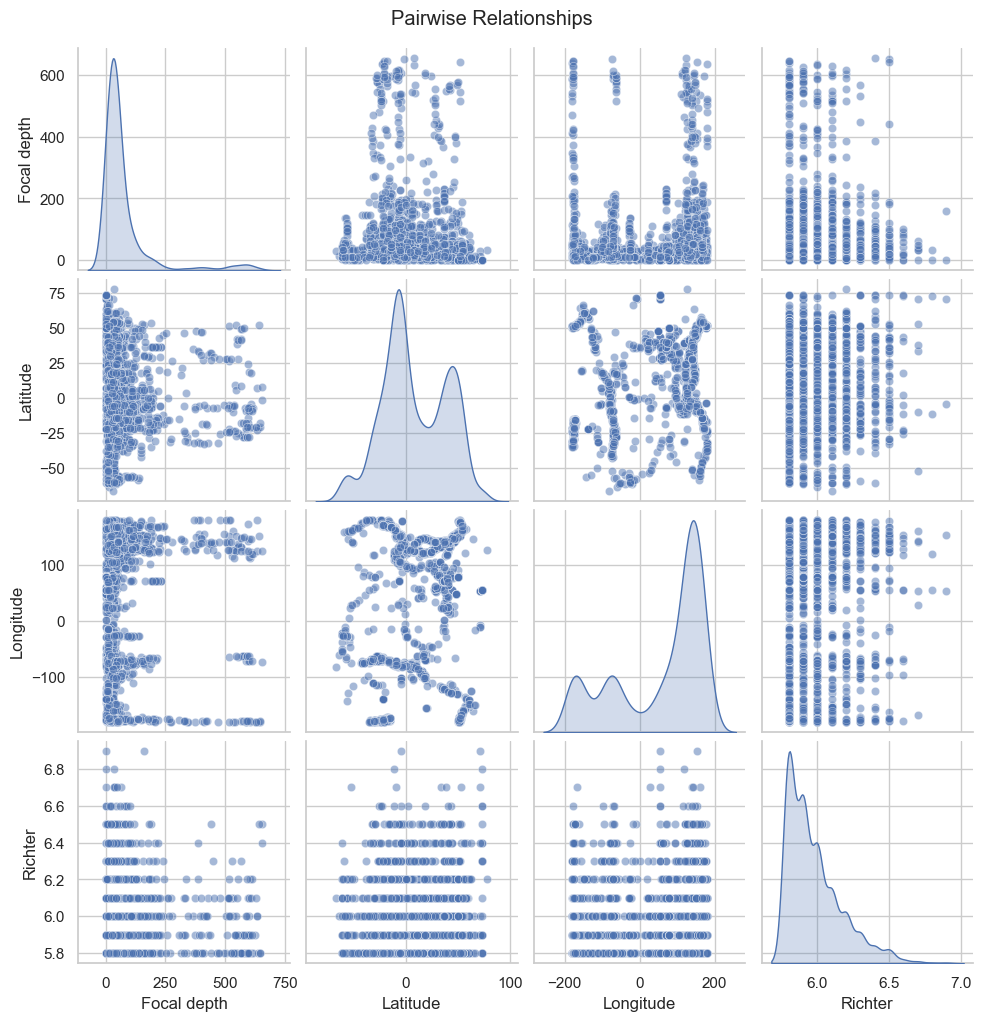

Correlation Matrix:


Focal depth  Latitude  Longitude   Richter
Focal depth     1.000000 -0.128579  -0.015103 -0.010146
Latitude       -0.128579  1.000000   0.135271  0.070499
Longitude      -0.015103  0.135271   1.000000 -0.020039
Richter        -0.010146  0.070499  -0.020039  1.000000

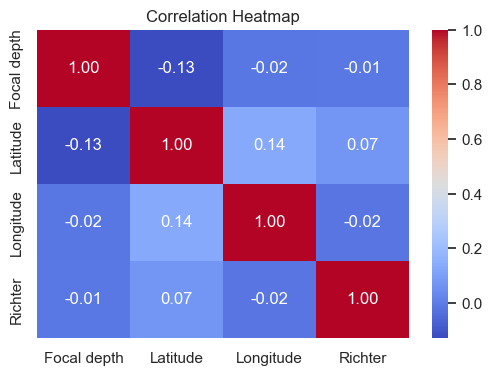

In [6]:
def multivariate_analysis(df: pd.DataFrame, numeric_cols: list):
 
    sns.pairplot(df[numeric_cols], diag_kind='kde', plot_kws={'alpha':0.5})
    plt.suptitle("Pairwise Relationships", y=1.02)
    plt.show()

   
    corr_matrix = df[numeric_cols].corr()
    print("Correlation Matrix:")
    display(corr_matrix)

    plt.figure(figsize=(6,4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


multivariate_analysis(df, numeric_columns)


I created this function in an intuitive way, but it is unnecessary here because this dataset is clean and does not have any missing values or similar issues.

In [7]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:

    df = df.dropna()
    

    df = df[df['Richter'] <= 10]
    df = df[df['Focal depth'] >= 0]


    return df




In [19]:
df_clean = clean_data(df)
print("After cleaning:", df_clean.shape)
df_clean.head(5)

After cleaning: (2178, 4)


Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
2           57     41.85     142.78      5.8
3           67     29.19     141.15      6.2
4           30    -21.66     169.81      6.0

These graphs are also unnecessary since there is no faulty data in this dataset.

In [9]:
def post_clean_outlier_check(df: pd.DataFrame, numeric_cols: list):

    fig, axes = plt.subplots(4,1, figsize=(6, 10))
    if len(numeric_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, numeric_cols):
        sns.boxplot(x=df[col], ax=ax)
        ax.set_title(f"Boxplot of {col} (After Cleaning)")
    plt.tight_layout()
    plt.show()



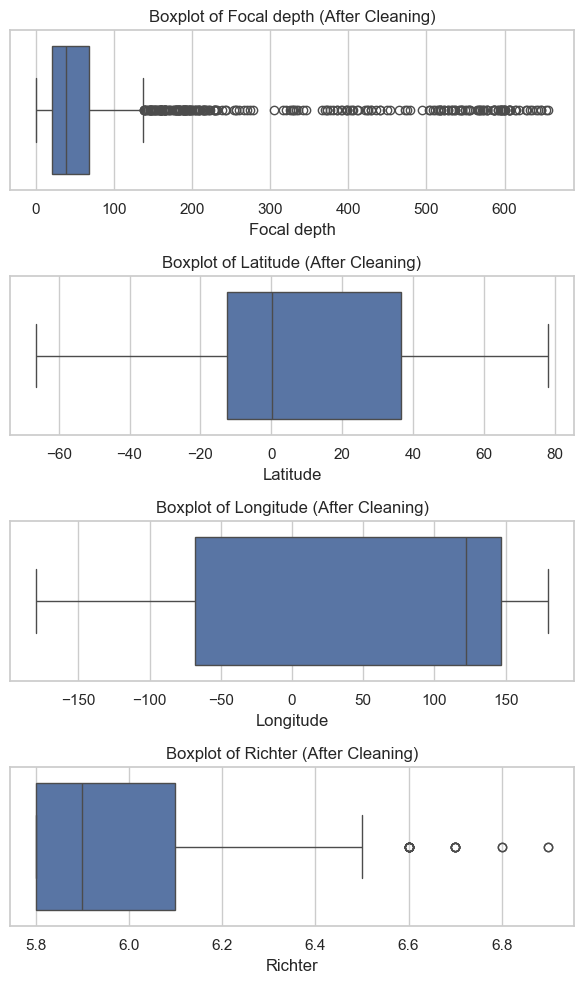

In [10]:

post_clean_outlier_check(df_clean, numeric_columns)


Here, I couldn't decide which scaler is better: RobustScaler or StandardScaler. However, since there are outliers in the dataset, RobustScaler might be a better choice. Still, I will keep the StandardScaler for further investigation, as I want to compare the differences in future examinations.

In [11]:
def scale_features_robust(df: pd.DataFrame, cols_to_scale: list) -> pd.DataFrame:

    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(df[cols_to_scale])
    df_scaled = pd.DataFrame(scaled_data, columns=cols_to_scale)
    return df_scaled





In [12]:
df_scaled = scale_features_robust(df_clean, numeric_columns)
print("Scaled data shape:", df_scaled.shape)
df_scaled.head()

Scaled data shape: (2178, 4)


Focal depth  Latitude  Longitude   Richter
0    -0.127660 -1.072732  -0.437006  2.666667
1    -0.063830  0.926553   0.134316 -0.333333
2     0.382979  0.851316   0.096346 -0.333333
3     0.595745  0.592487   0.088752  1.000000
4    -0.191489 -0.447125   0.222277  0.333333

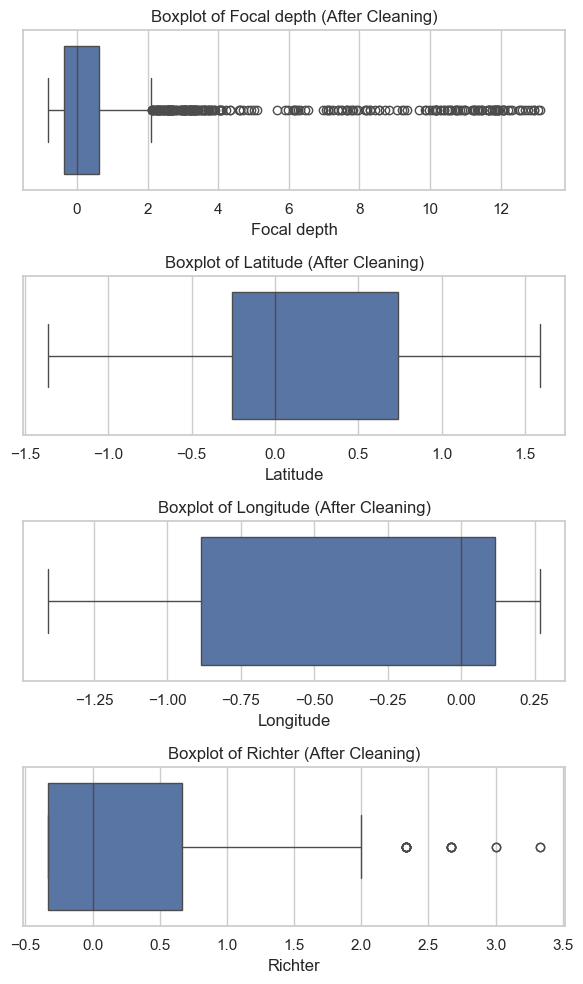

In [13]:

post_clean_outlier_check(df_scaled, numeric_columns)


In [14]:


def scale_features_zscore(df: pd.DataFrame, cols_to_scale: list) -> pd.DataFrame:

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[cols_to_scale])
    df_scaled = pd.DataFrame(scaled_data, columns=cols_to_scale)
    return df_scaled




In [15]:
df_scaled_zscore = scale_features_zscore(df_clean, numeric_columns)
print("Scaled data shape:", df_scaled.shape)
df_scaled_zscore.head()

Scaled data shape: (2178, 4)


Focal depth  Latitude  Longitude   Richter
0    -0.355201 -1.971998  -0.223940  3.816707
1    -0.329437  1.230182   0.807880 -0.935570
2    -0.149088  1.109679   0.739305 -0.935570
3    -0.063208  0.695121   0.725590  1.176553
4    -0.380965 -0.969986   0.966738  0.120492

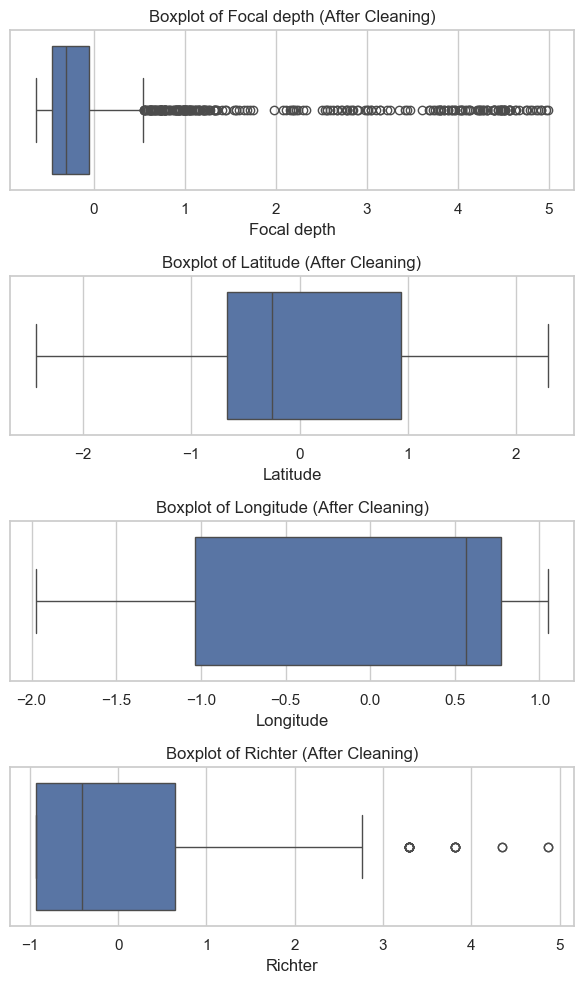

In [16]:

post_clean_outlier_check(df_scaled_zscore, numeric_columns)


Here, I simply visualized the original dataset on a world map.

In [24]:
def plot_geographic_distribution(df: pd.DataFrame, lat_col: str, lon_col: str):

    plt.figure(figsize=(10,6))
    plt.scatter(df[lon_col], df[lat_col], alpha=0.5, c='red', edgecolors='black')
    plt.title("Earthquake Locations")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()



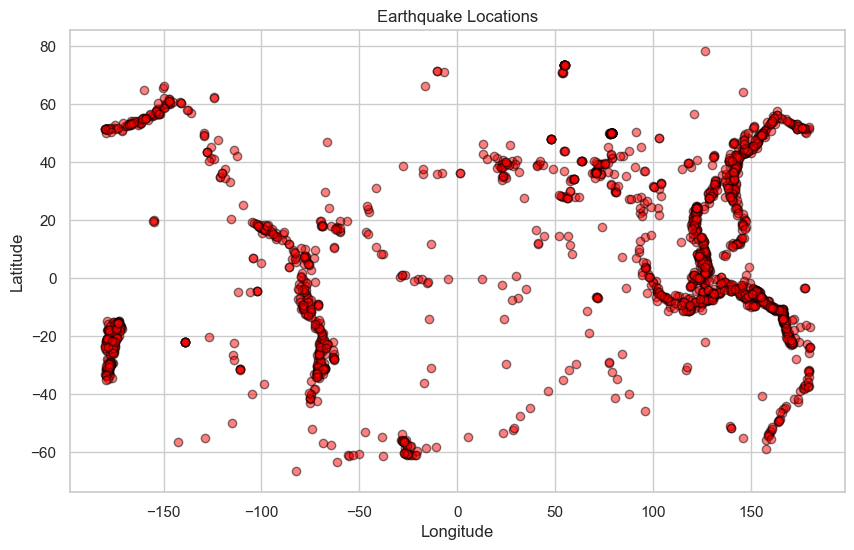

In [25]:
plot_geographic_distribution(df_clean, 'Latitude', 'Longitude')

When we look at the maps, we can clearly see that at least three different areas have a significant number of earthquakes.

In [26]:


def plot_on_world_map(df: pd.DataFrame, lat_col: str, lon_col: str):

    world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col])
    )


    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color='white', edgecolor='black')
    gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7)
    plt.title("Earthquake Locations on World Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()




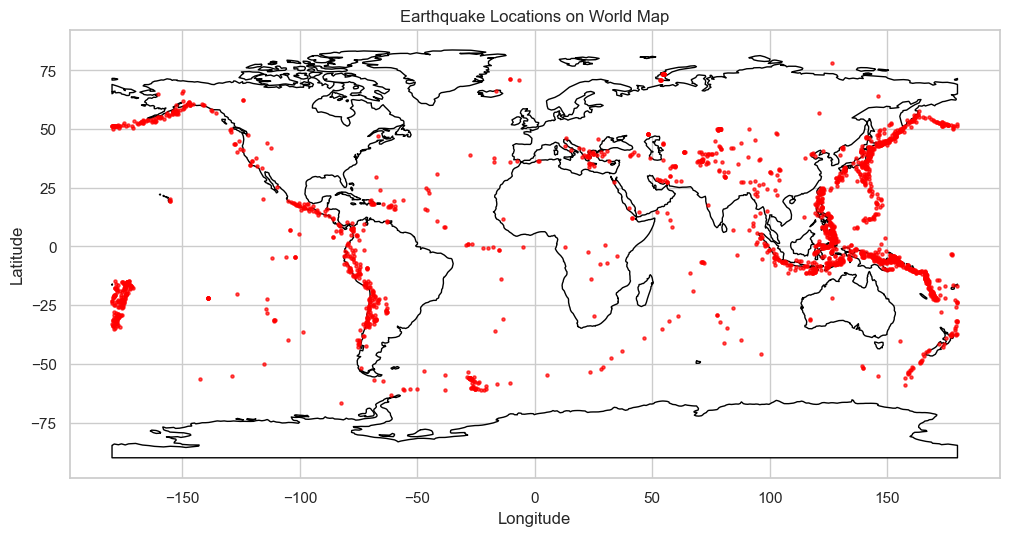

In [31]:
plot_on_world_map(df_clean, 'Latitude', 'Longitude')

In [32]:


def plot_on_world_map(df: pd.DataFrame, lat_col: str, lon_col: str):

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.coastlines()

    ax.scatter(df[lon_col], df[lat_col], color='red', marker='o', s=5, alpha=0.7, transform=ccrs.PlateCarree())

    plt.title("Earthquake Locations on World Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()





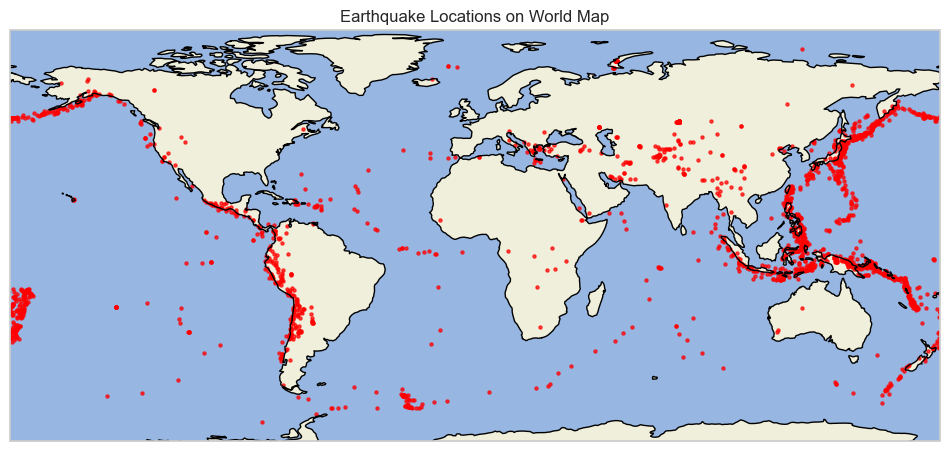

In [34]:
plot_on_world_map(df_clean, 'Latitude', 'Longitude')

Summary of the First Part:

*Dataset Overview
  We reviewed our dataset and found nothing unusual. Everything is clean—there are no missing values, no faulty data, and no significant anomalies.  

EDA (Exploratory Data Analysis) 
  We conducted a classical EDA. In the univariate analysis, we examined the distributions of the features.  

Multivariate Analysis
  We checked for correlations between features, but no significant correlations were found.  

Data Scaling  
  For the modeling part, we scaled the data. Since we are using machine learning models, scaling is crucial to handle outliers and for the mathematical calculations required by the algorithms. Both RobustScaler and StandardScaler were considered, with RobustScaler being preferred due to the presence of outliers, but StandardScaler was retained for further comparison.  

Visualization  
  Lastly, we visualized the dataset on charming world maps to better understand the geographical distribution of earthquakes.  

Here, we are performing an elbow analysis to determine the point after which increasing the number of clusters becomes meaningless. This is important for two reasons:

Computational Limitations: Increasing the number of clusters unnecessarily can lead to higher computational costs without adding value.
Business Perspective: The purpose of clustering is to identify distinct groups. If two clusters are very similar, it defeats the purpose of clustering and provides little business insight.
In this analysis, we use the inertia value (sum of squared distances between points and their respective cluster centers) to understand where the curve starts to flatten. This "sweet spot" represents the optimal number of clusters where adding more clusters no longer significantly improves the results.

In [37]:
def elbow_method(data, max_clusters=20):

    inertia_values = []
    cluster_range = range(2, max_clusters+1)
    for k in cluster_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(data)
        inertia_values.append(km.inertia_)


    plt.figure(figsize=(8,4))
    plt.plot(cluster_range, inertia_values, 'o-', color='blue')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster SSE)')
    plt.show()

    return inertia_values


I also performed the elbow analysis on both the original dataset and the scaled versions to observe and compare the results. This helps in understanding how scaling impacts the clustering process and the determination of the optimal number of clusters.

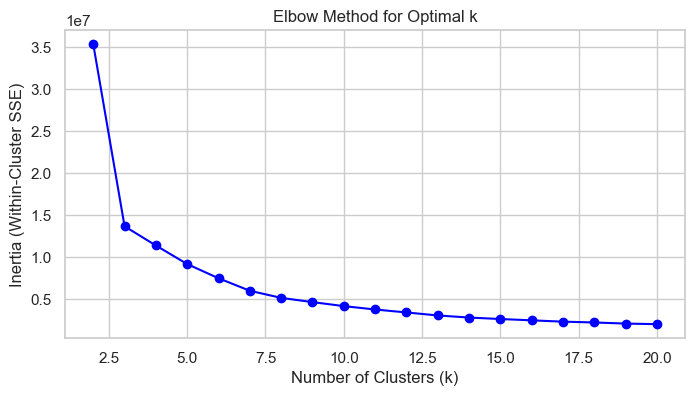

In [40]:
inertia_vals = elbow_method(df_clean, max_clusters=20)

Based on this analysis, the sweet spot for the number of clusters lies between 2 and 4. This range provides a good balance, avoiding unnecessary complexity while capturing meaningful groupings.

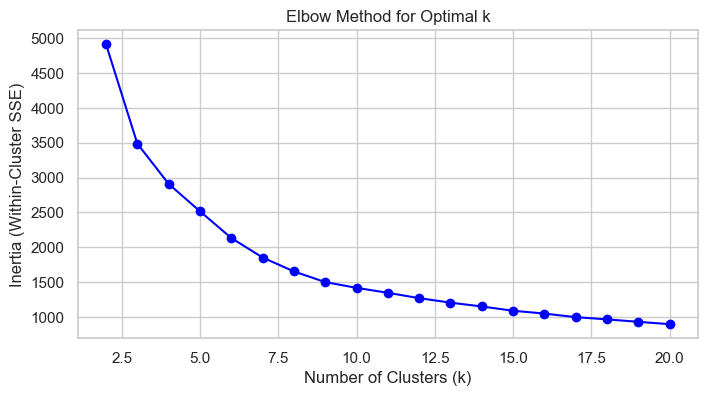

In [41]:
inertia_vals = elbow_method(df_scaled, max_clusters=20)

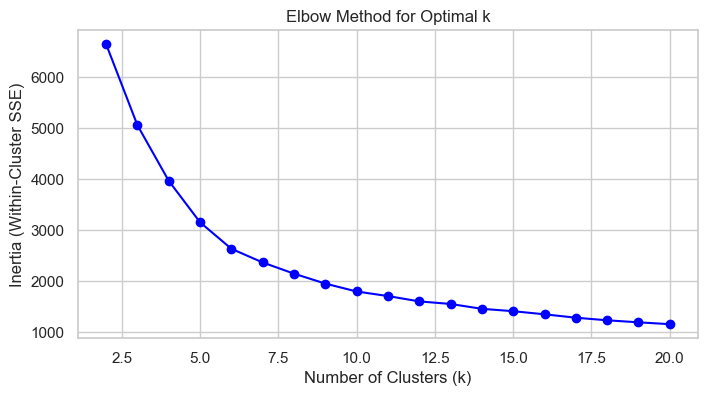

In [42]:
inertia_vals = elbow_method(df_scaled_zscore, max_clusters=20)

Here, we will perform a gap analysis. This is a straightforward approach where we create a reference dataset with the same size and distribution as the original dataset. Then, we compare the clustering results of the original dataset against the reference dataset to assess the quality and significance of the clustering.

In [48]:

def gap_statistic(data, refs=10, max_clusters=20):

    shape = data.shape

    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    gaps = []
    sks = []

    cluster_range = range(1, max_clusters+1)
    for k in cluster_range:

        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(data)
        disp = km.inertia_

        ref_disps = np.zeros(refs)
        for i in range(refs):
            random_data = np.random.uniform(min_vals, max_vals, size=shape)
            km_ref = KMeans(n_clusters=k, random_state=i, n_init=10)
            km_ref.fit(random_data)
            ref_disps[i] = km_ref.inertia_

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        sk = np.sqrt(1 + (1.0/refs)) * np.std(np.log(ref_disps))
        gaps.append(gap)
        sks.append(sk)

    best_k = 1
    for i in range(len(gaps)-1):
        if gaps[i] >= gaps[i+1] - sks[i+1]:
            best_k = i+1
            break

    plt.figure(figsize=(8,4))
    plt.plot(cluster_range, gaps, 'o-', color='red')
    plt.title('Gap Statistic')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Gap Value')
    plt.show()

    print("Gap Statistic Recommended k:", best_k)

    return gaps, sks, best_k



When I observed the results, I found it a bit intriguing that the lowest point occurred between 2.5 and 5.0. This made me realize that this is not the only general metric to rely on. I need to consider other metrics simultaneously to make a well-rounded decision. After reviewing those metrics, I assumed that 3 is again a good choice, aligning with the findings from the elbow analysis.

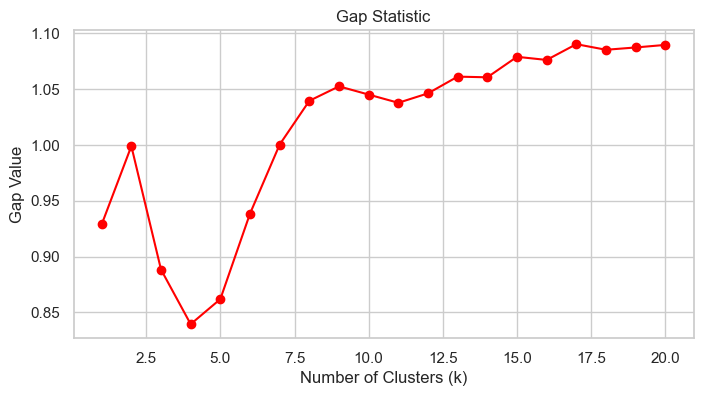

Gap Statistic Recommended k: 2


In [50]:
gaps, sks, gap_k = gap_statistic(df_scaled, refs=20, max_clusters=20)

As mentioned earlier, if two clusters are very similar, it is not an effective clustering approach. Silhouette analysis addresses this by comparing the similarity of data points within the same cluster and measuring their separation from other clusters. It helps evaluate how well-defined the clusters are and ensures that each cluster is distinct and meaningful.

In [51]:
def silhouette_analysis(data, range_n_clusters):

    silhouette_scores = []

    for k in range_n_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(8,4))
    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.title("Silhouette Analysis")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Average Silhouette Score")
    plt.show()

    best_k = range_n_clusters[np.argmax(silhouette_scores)]
    print("Best k based on silhouette score:", best_k)
    
    return silhouette_scores, best_k



Once again, I was stuck with my choice. While the numerical values suggest that 2 clusters might be better, when I look at the plots, 3 clusters appear to provide a more meaningful and visually clear separation. Therefore, I believe 3 is the overall better choice.

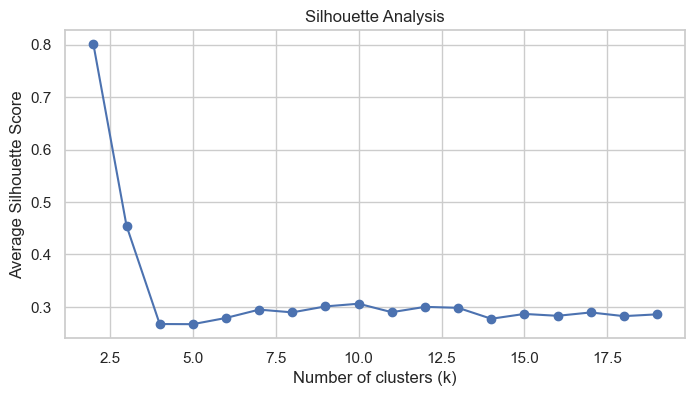

Best k based on silhouette score: 2


In [53]:
sil_range = range(2, 20)
sil_scores, best_k_sil = silhouette_analysis(df_scaled, sil_range)

This step involves understanding the clustering visually using silhouette analysis. The analysis highlights the overlapping between clusters and provides an average silhouette score line to ensure that the scores align with the clustering quality. Generally, we prefer silhouette values greater than 0.5, as they indicate well-defined clusters. However, in this case, the value for 2 clusters seems too suspicious, reinforcing the need to carefully interpret the results beyond just numerical scores.

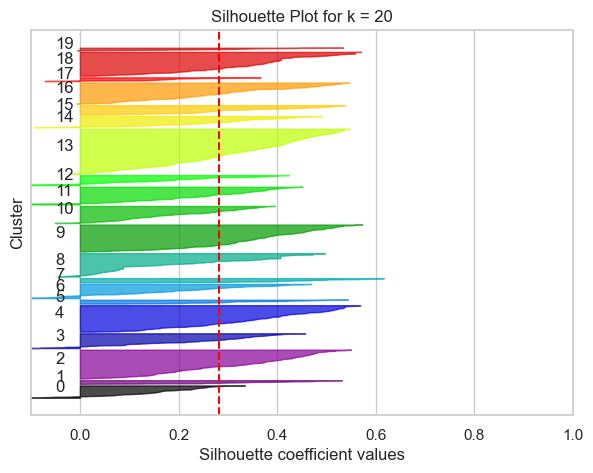

Average silhouette score for k=20: 0.281


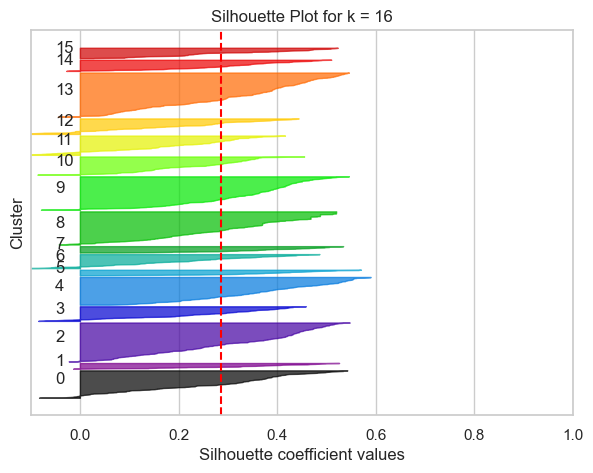

Average silhouette score for k=16: 0.286


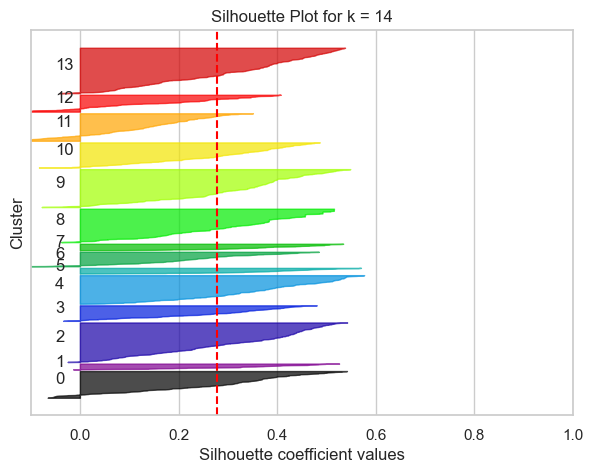

Average silhouette score for k=14: 0.277


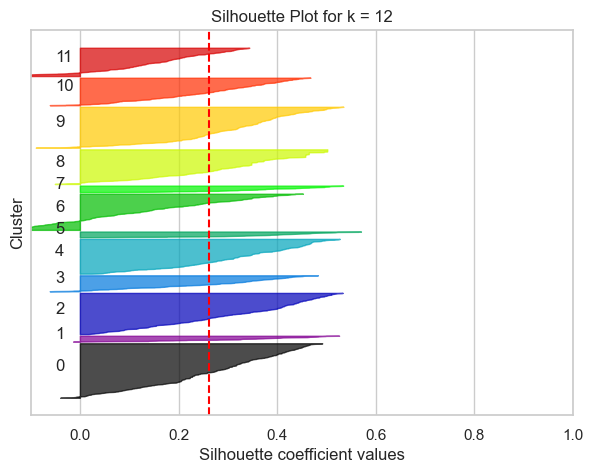

Average silhouette score for k=12: 0.262


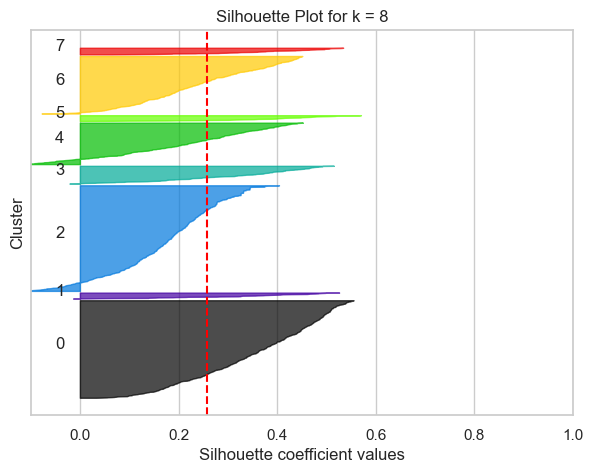

Average silhouette score for k=8: 0.258


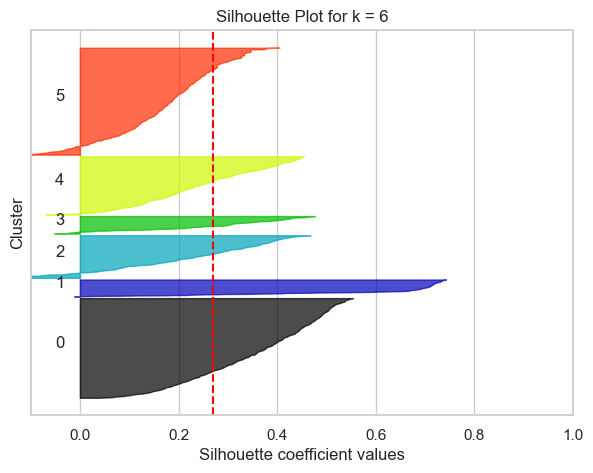

Average silhouette score for k=6: 0.27


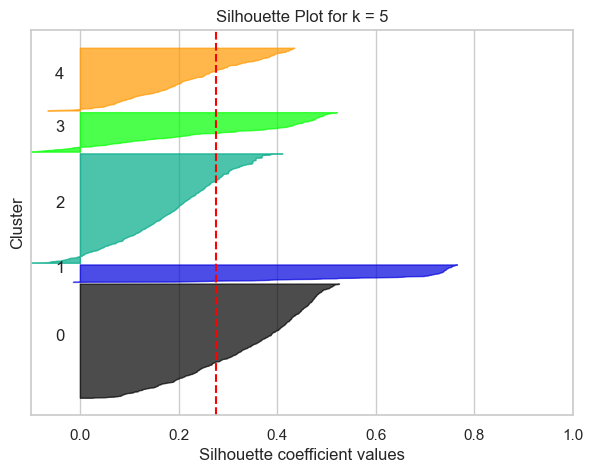

Average silhouette score for k=5: 0.276


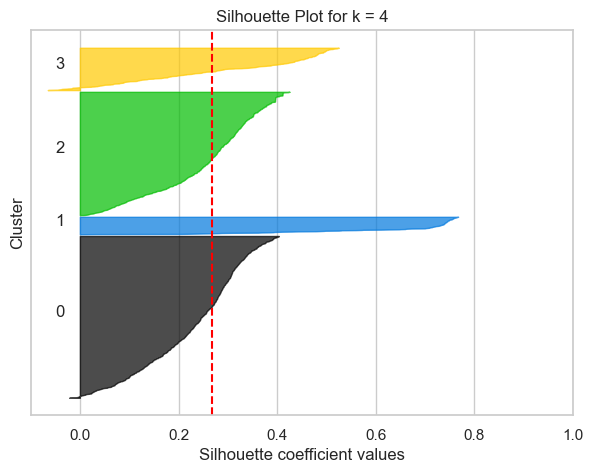

Average silhouette score for k=4: 0.268


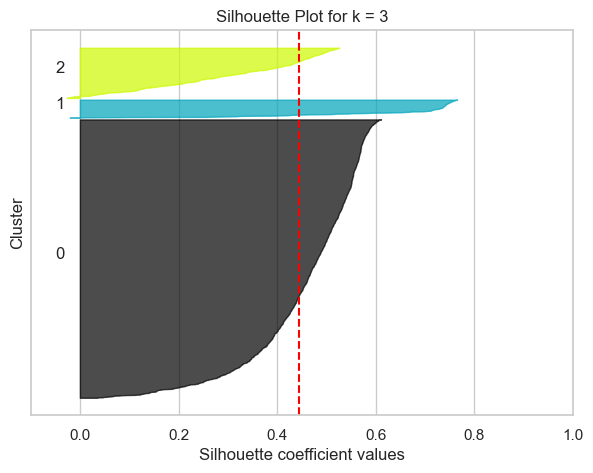

Average silhouette score for k=3: 0.445


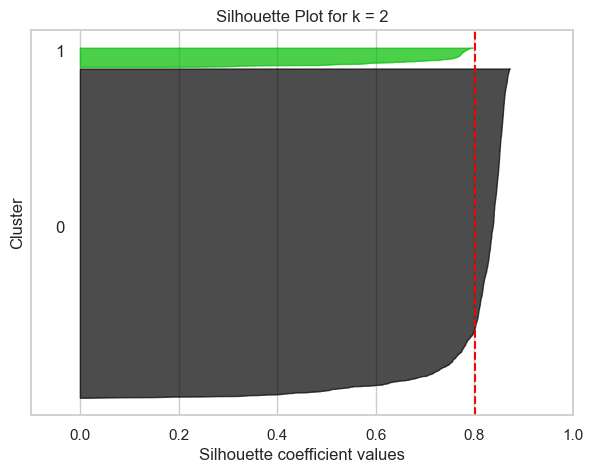

Average silhouette score for k=2: 0.801


In [54]:
def detailed_silhouette_plot(data, k):

    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
    

    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(data)
    silhouette_vals = silhouette_samples(data, labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_sil_vals = silhouette_vals[labels == i]
        ith_cluster_sil_vals.sort()
        y_upper = y_lower + len(ith_cluster_sil_vals)

        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_sil_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, (y_lower + y_upper) / 2, str(i))
        y_lower = y_upper + 10  

    ax1.set_title(f"Silhouette Plot for k = {k}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster")

    avg_score = np.mean(silhouette_vals)
    ax1.axvline(x=avg_score, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xlim([-0.1, 1])
    plt.show()

    print(f"Average silhouette score for k={k}:", round(avg_score, 3))

detailed_silhouette_plot(df_scaled, k=20)
detailed_silhouette_plot(df_scaled, k=16)
detailed_silhouette_plot(df_scaled, k=14)
detailed_silhouette_plot(df_scaled, k=12)
detailed_silhouette_plot(df_scaled, k=8)
detailed_silhouette_plot(df_scaled, k=6)
detailed_silhouette_plot(df_scaled, k=5)
detailed_silhouette_plot(df_scaled, k=4)
detailed_silhouette_plot(df_scaled, k=3)
detailed_silhouette_plot(df_scaled, k=2)


In [100]:
chosen_k = 2  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")


K-means with 2 clusters fitted.


Now comes the visualization part. Here, I used both 3D and 2D plots based on PCA (Principal Component Analysis) applied to different datasets and scaling methods. Some of the visualizations show overlapping clusters, indicating less distinct separation. Additionally, I visualized the dataset with 15 clusters to observe the effects of a higher number of clusters and to better understand the data's structure in a high-dimensional space.

In [101]:
 

def plot_3d_clusters(df_scaled, labels, chosen_k):

    if isinstance(df_scaled, pd.DataFrame):
        df_scaled = df_scaled.values
        
    pca = PCA(n_components=3)
    df_reduced = pca.fit_transform(df_scaled)

    x = df_reduced[:, 0]
    y = df_reduced[:, 1]
    z = df_reduced[:, 2]


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(x, y, z, c=labels, cmap='viridis', s=50, alpha=0.7)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'3D K-Means Clustering (k={chosen_k})')

    color_bar = fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
    color_bar.set_label('Cluster Label')

    plt.show()


In [102]:
def visualize_clusters_2d(data, labels, title='Cluster Visualization'):

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='tab10', s=30)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()




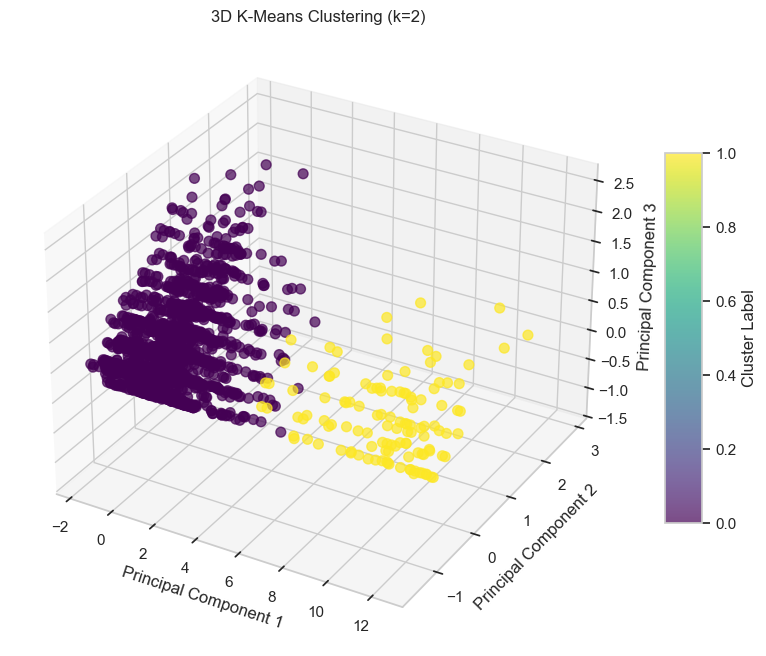

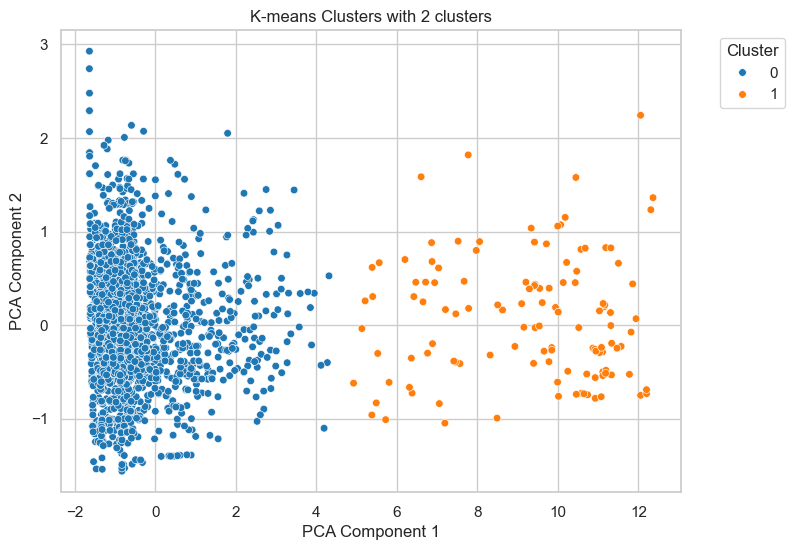

In [103]:
plot_3d_clusters(df_scaled, labels, chosen_k)
visualize_clusters_2d(df_scaled, labels, title='K-means Clusters with 2 clusters')


In [71]:
chosen_k = 2  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled_zscore)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")


K-means with 2 clusters fitted.


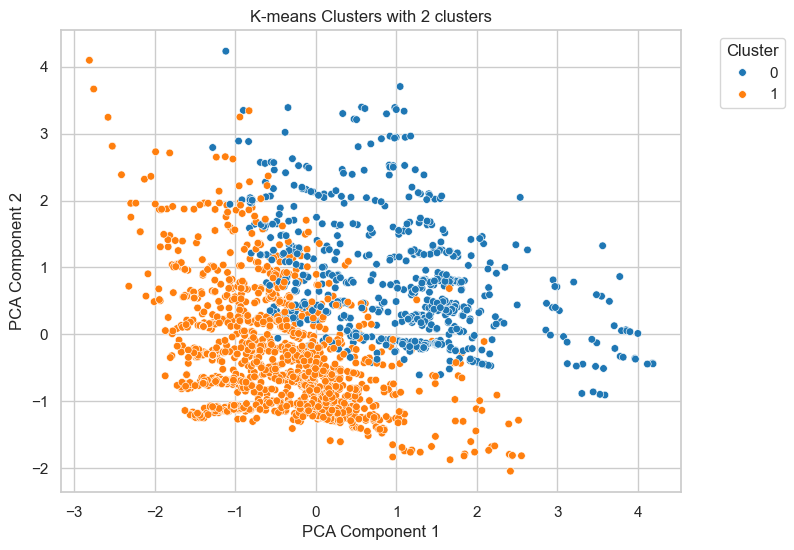

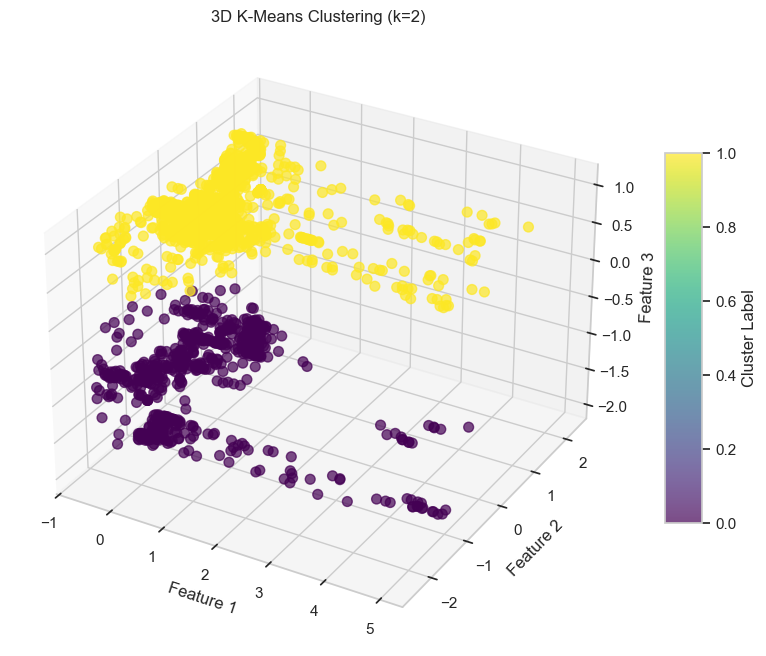

In [72]:
visualize_clusters_2d(df_scaled_zscore, labels, title='K-means Clusters with 2 clusters')
plot_3d_clusters(df_scaled_zscore, labels, chosen_k)

In [73]:
chosen_k = 3  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 3 clusters fitted.


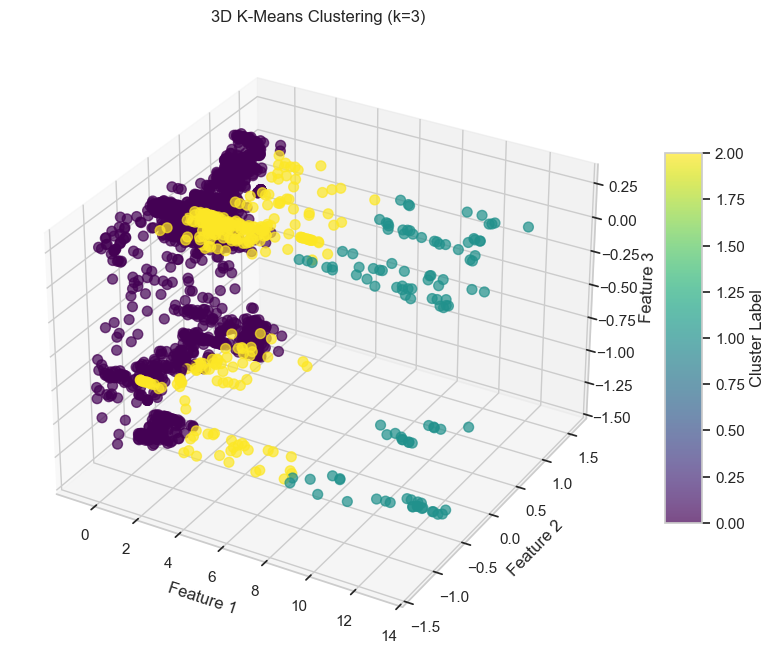

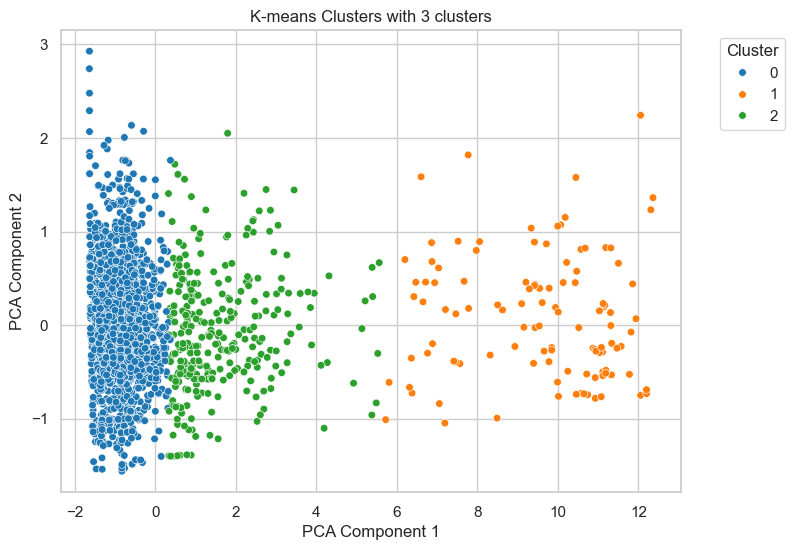

In [74]:
plot_3d_clusters(df_scaled, labels, chosen_k)
visualize_clusters_2d(df_scaled, labels, title='K-means Clusters with 3 clusters')


In [75]:
chosen_k = 3  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled_zscore)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 3 clusters fitted.


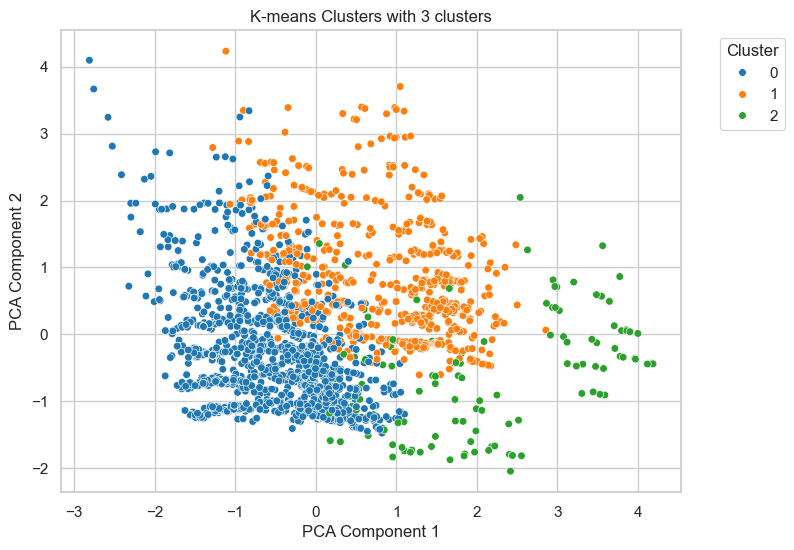

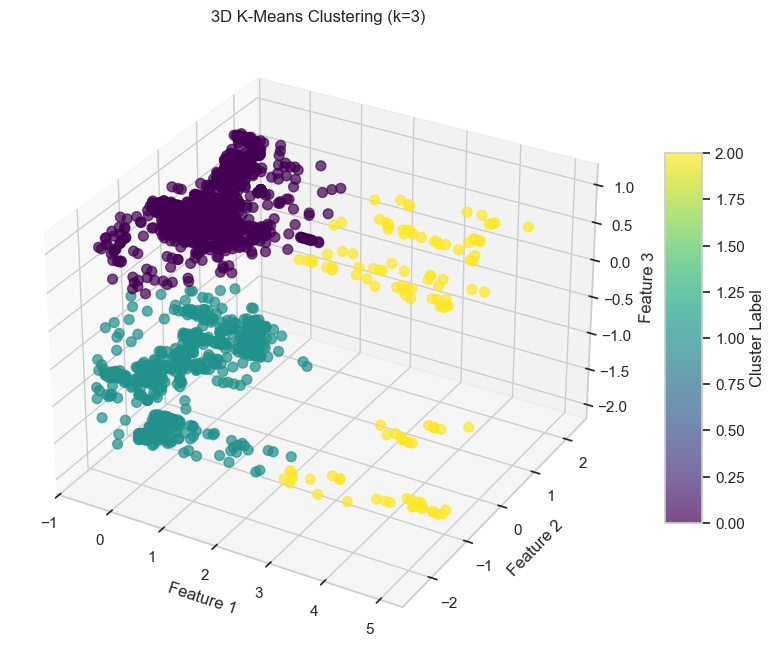

In [76]:
visualize_clusters_2d(df_scaled_zscore, labels, title='K-means Clusters with 3 clusters')
plot_3d_clusters(df_scaled_zscore, labels, chosen_k)

In [77]:
chosen_k = 4 

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 4 clusters fitted.


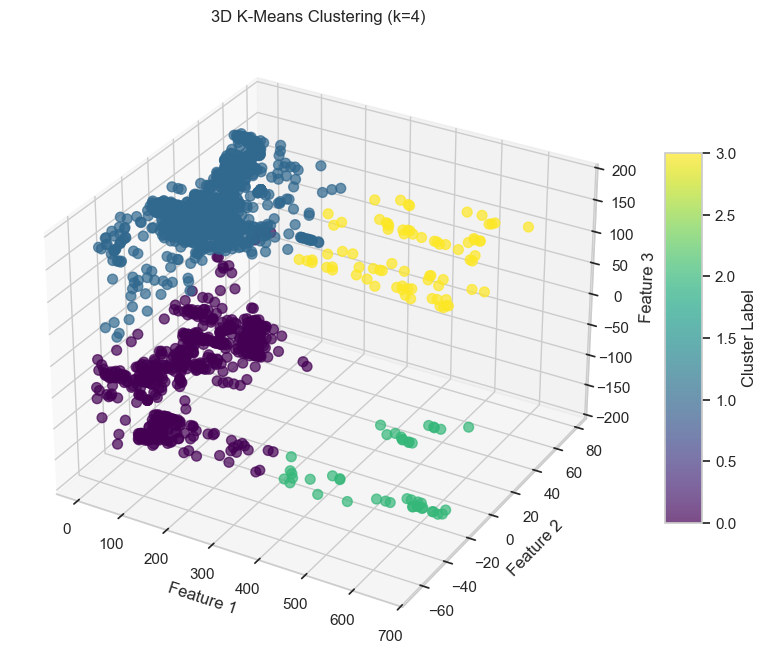

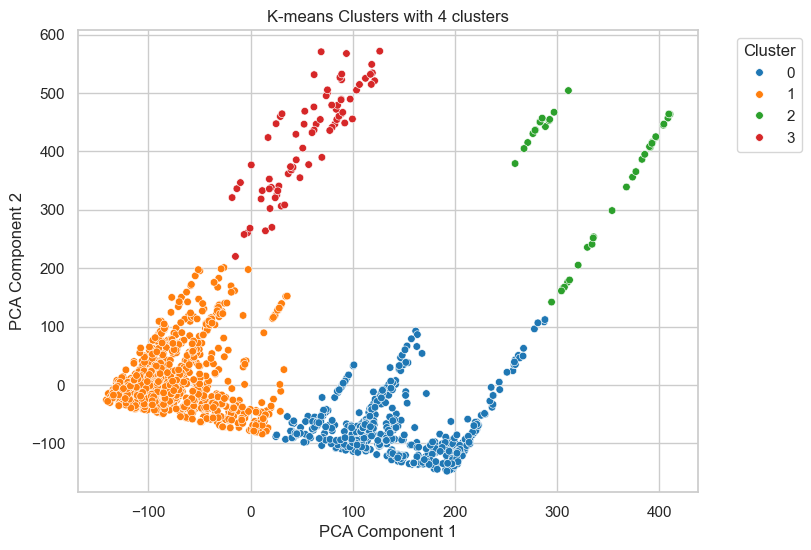

In [78]:
plot_3d_clusters(df, labels, chosen_k)
visualize_clusters_2d(df, labels, title='K-means Clusters with 4 clusters')

In [80]:
chosen_k = 4  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 4 clusters fitted.


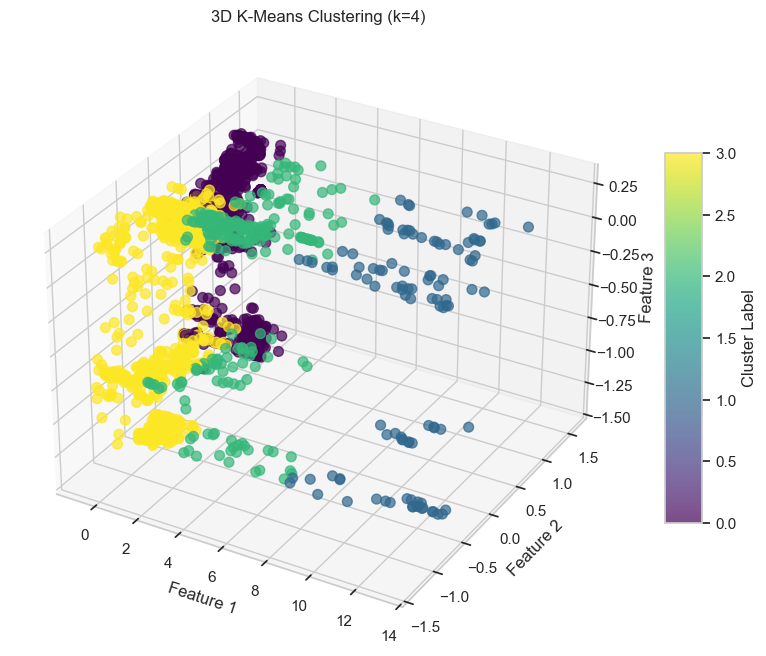

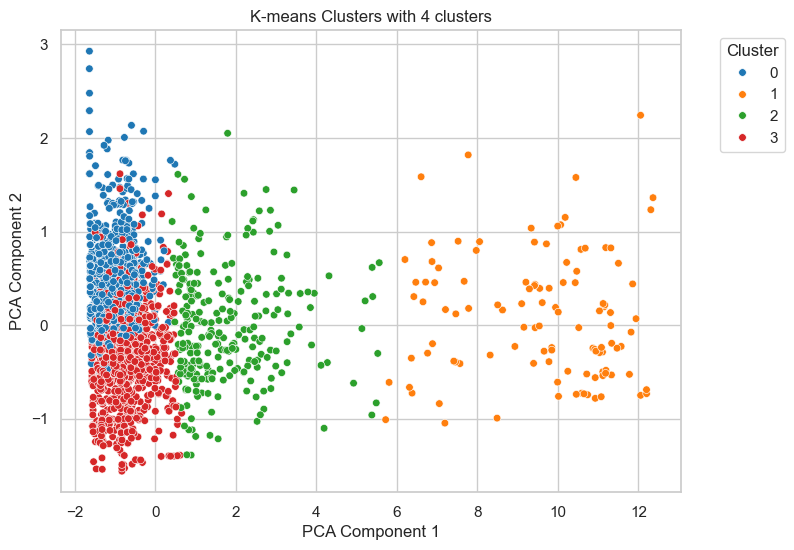

In [81]:
plot_3d_clusters(df_scaled, labels, chosen_k)
visualize_clusters_2d(df_scaled, labels, title='K-means Clusters with 4 clusters')

In [82]:
chosen_k = 4  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled_zscore)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 4 clusters fitted.


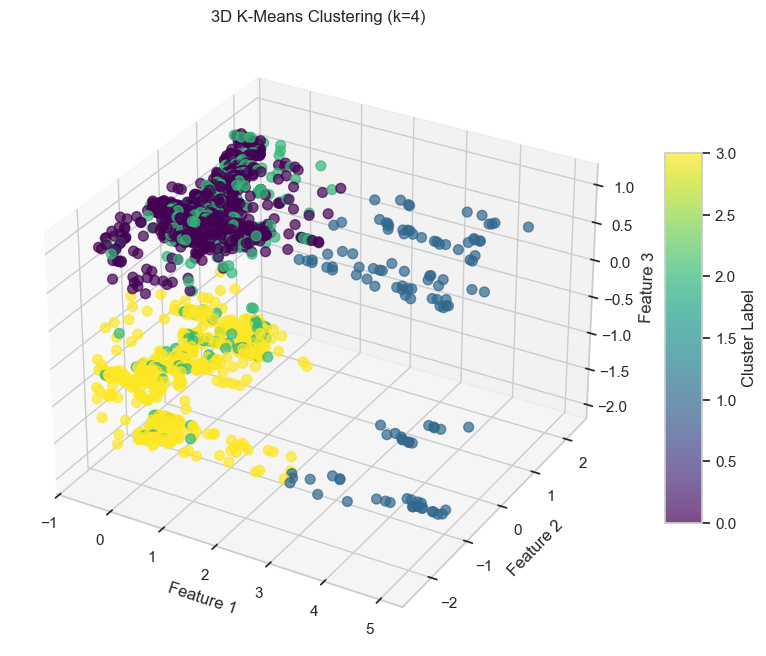

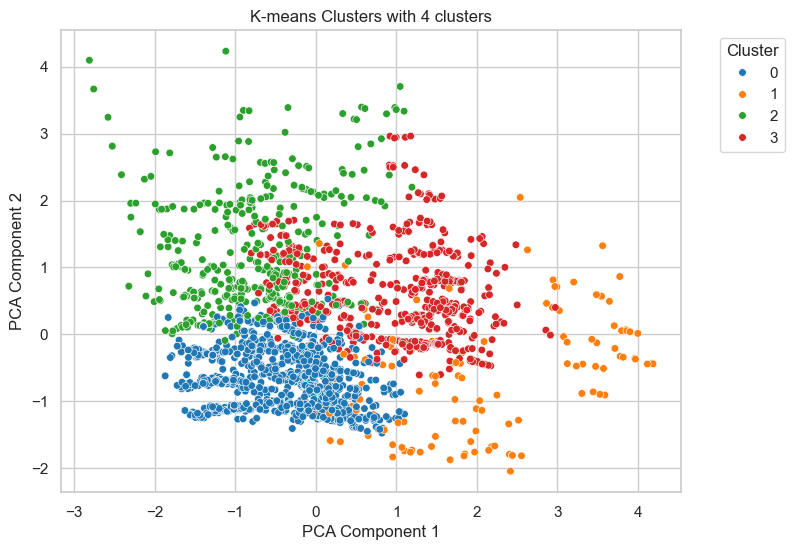

In [83]:
plot_3d_clusters(df_scaled_zscore, labels, chosen_k)
visualize_clusters_2d(df_scaled_zscore, labels, title='K-means Clusters with 4 clusters')

In [84]:
chosen_k = 15  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 15 clusters fitted.


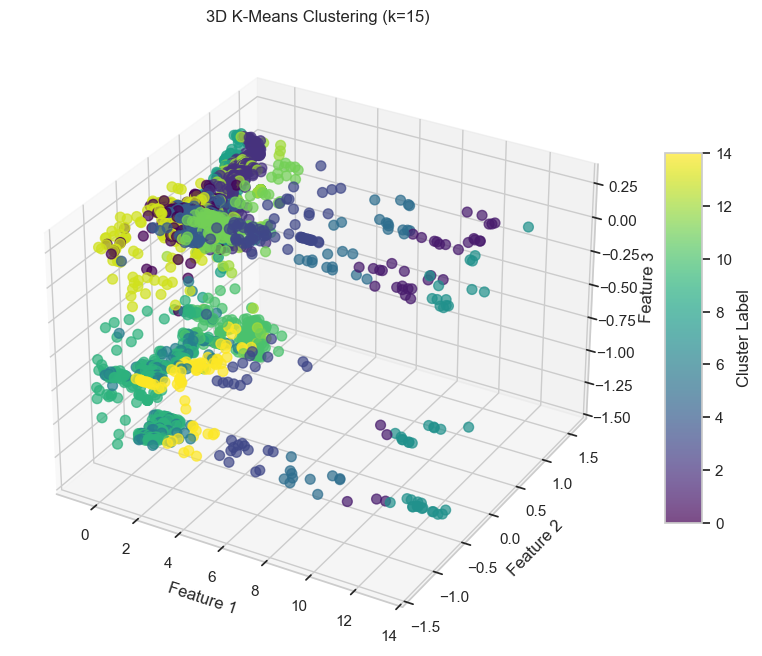

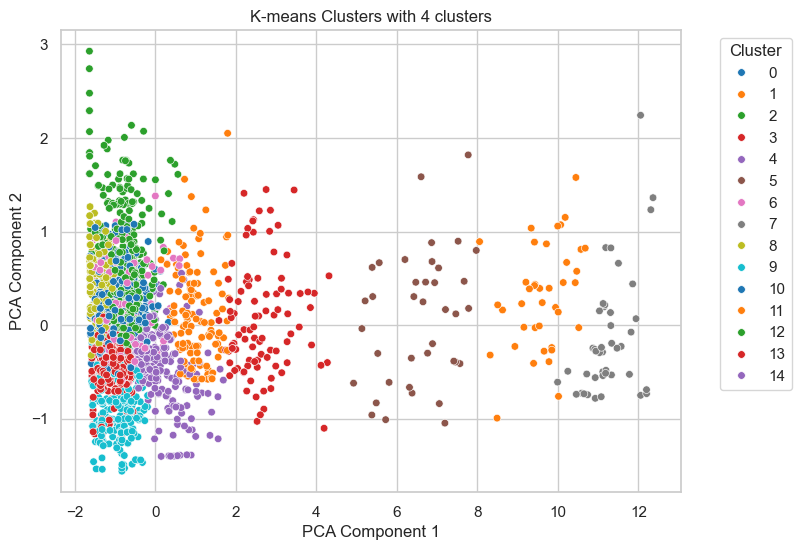

In [86]:
plot_3d_clusters(df_scaled, labels, chosen_k)
visualize_clusters_2d(df_scaled, labels, title='K-means Clusters with 4 clusters')

In [87]:
chosen_k = 15  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 15 clusters fitted.


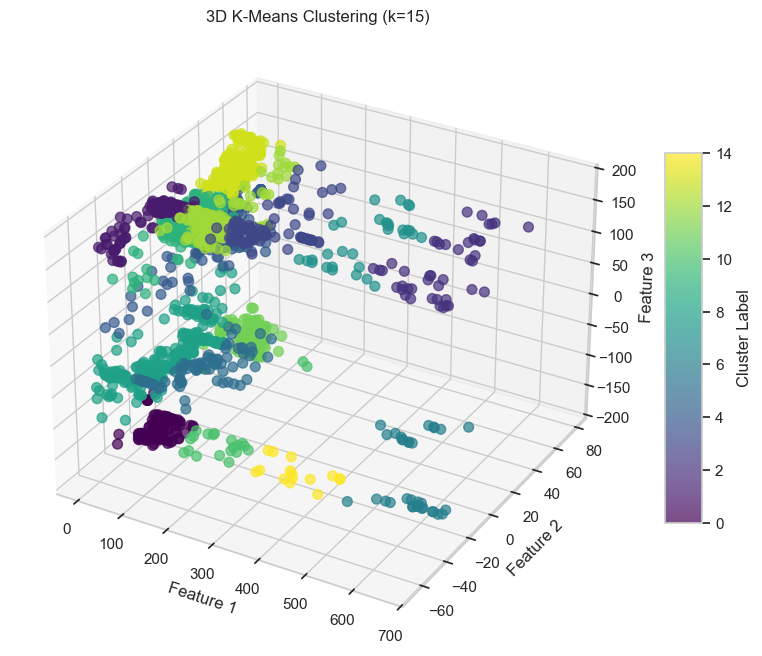

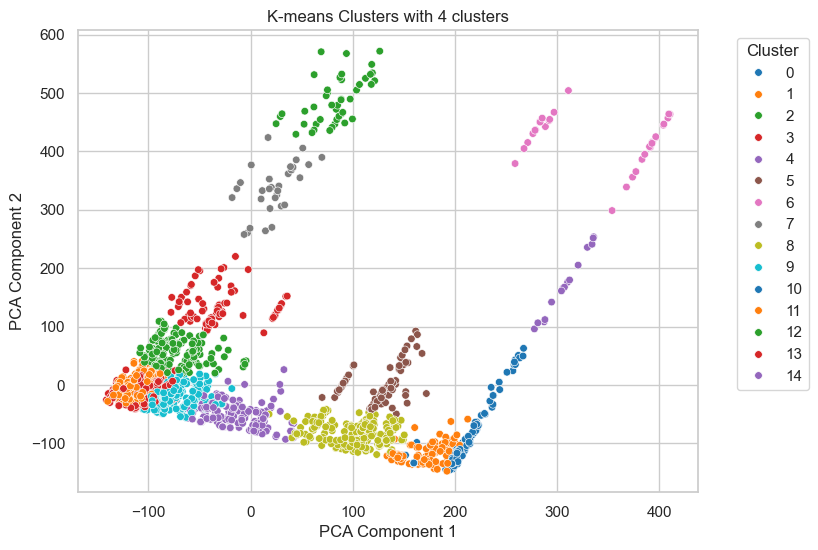

In [88]:
plot_3d_clusters(df, labels, chosen_k)
visualize_clusters_2d(df, labels, title='K-means Clusters with 4 clusters')

In [90]:
chosen_k = 15 

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled_zscore)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 15 clusters fitted.


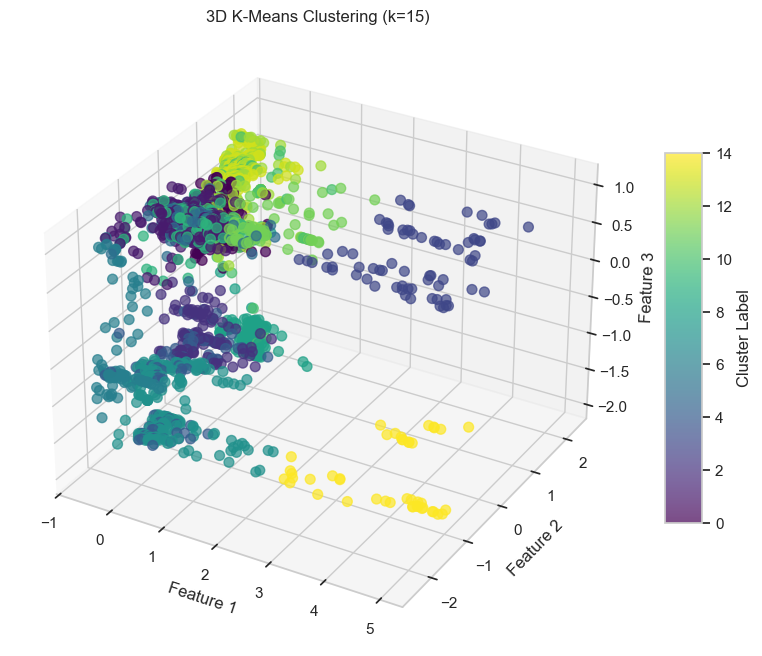

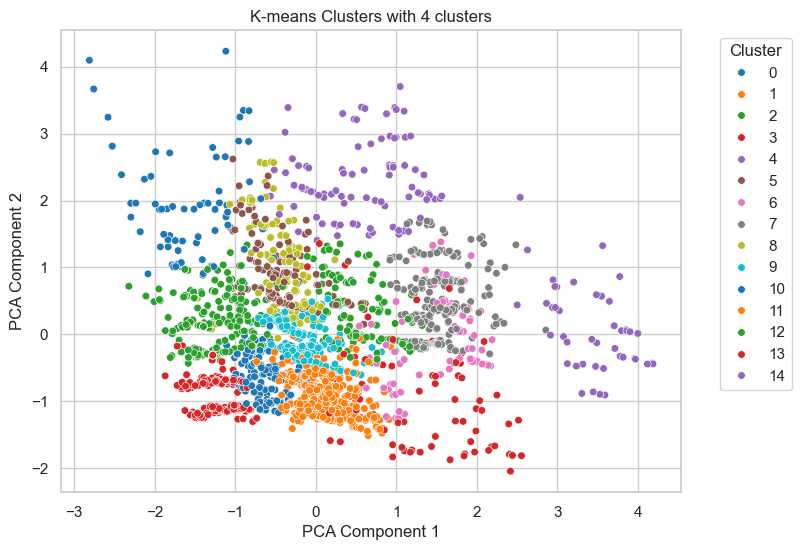

In [91]:
plot_3d_clusters(df_scaled_zscore, labels, chosen_k)
visualize_clusters_2d(df_scaled_zscore, labels, title='K-means Clusters with 4 clusters')

In [92]:
chosen_k = 3  

kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")
 

K-means with 3 clusters fitted.


When I ran the 2D and 3D visualizations with PCA, some of the results did not provide clear insights or intuitive patterns. I primarily used these visualizations to compare the results with other methods. To gain a deeper understanding, I decided to analyze the effects feature by feature, similar to the EDA process. While some features provided understandable insights, others remained unclear and did not contribute much to the overall intuition.

In [95]:
 
def visualize_clusters_2d(data, labels, column_names, title='Cluster Visualization'):

    combinations = list(itertools.combinations(column_names, 2))
    
    for col_x, col_y in combinations:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=data[col_x], y=data[col_y], hue=labels, palette='tab10', s=30)
        plt.title(f'{title}: {col_x} vs {col_y}')
        plt.xlabel(col_x)
        plt.ylabel(col_y)
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()



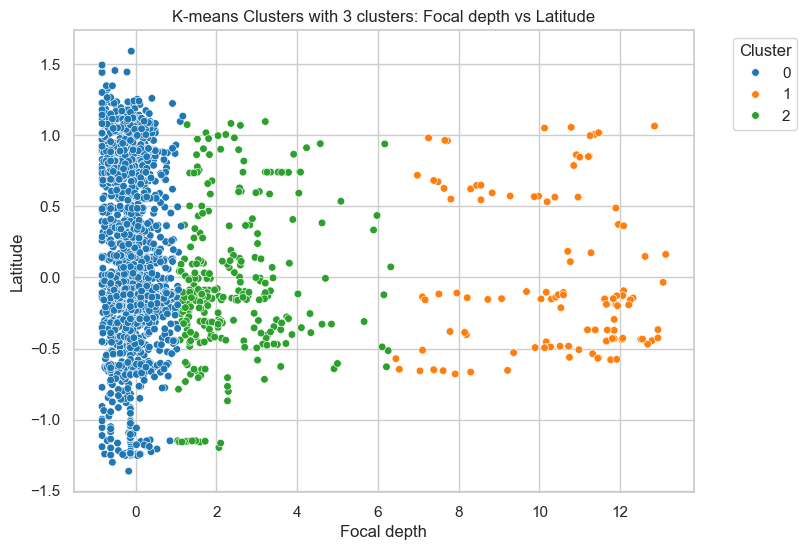

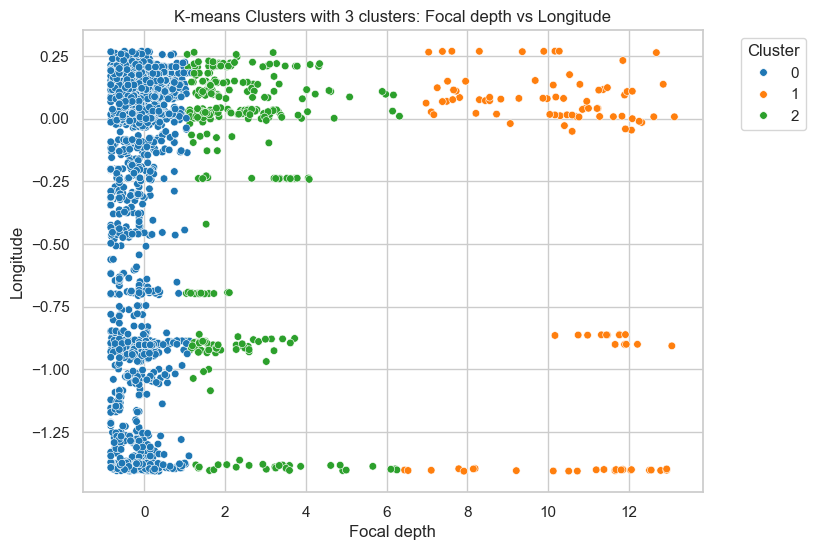

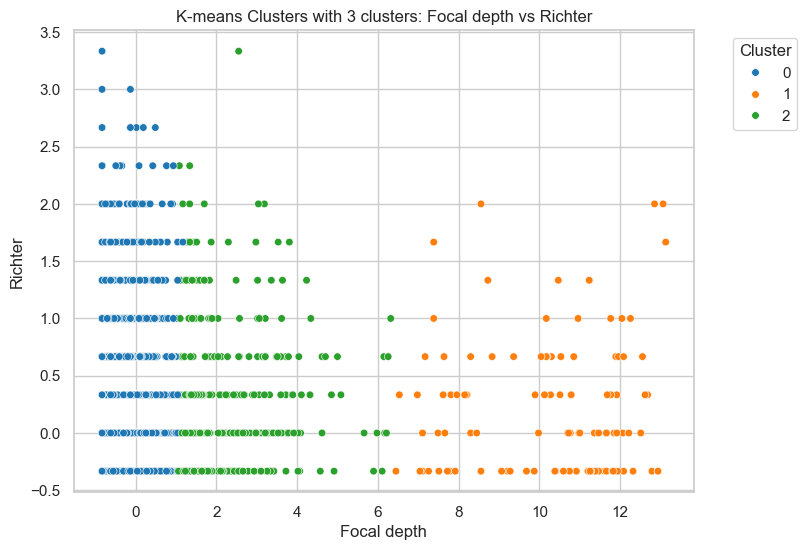

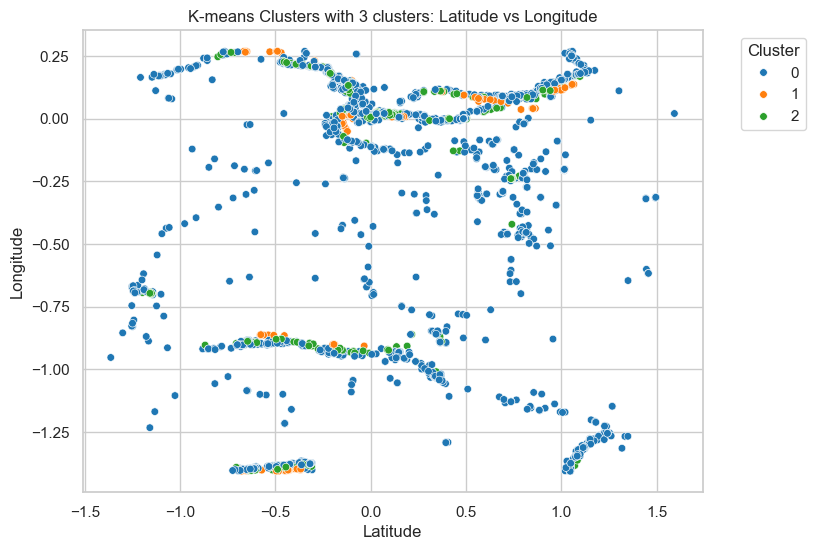

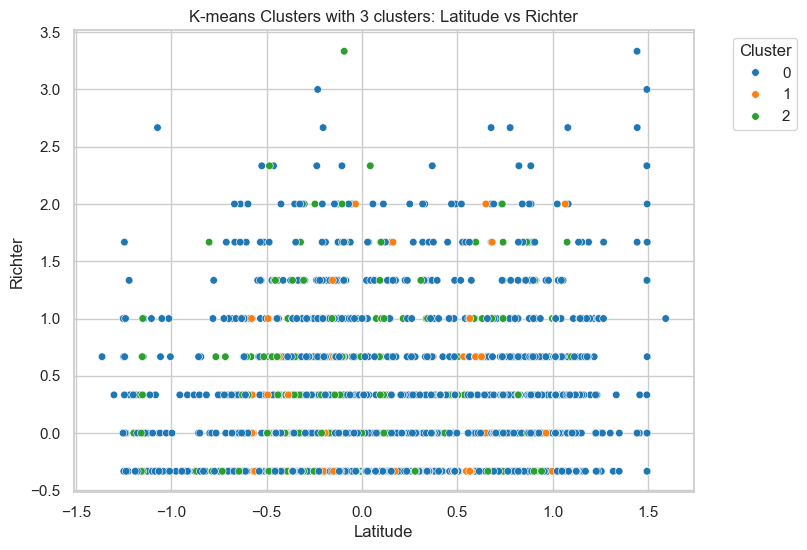

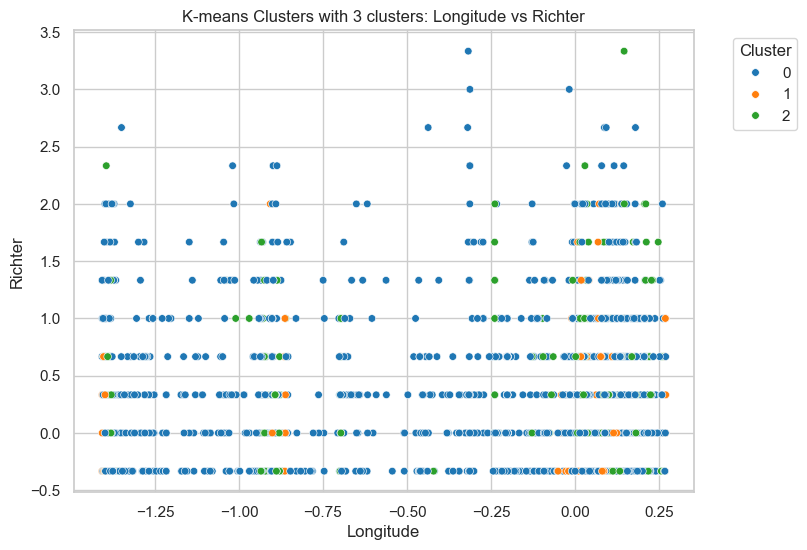

In [96]:
column_names = ['Focal depth', 'Latitude', 'Longitude', 'Richter']
visualize_clusters_2d(df_scaled, labels, column_names, title='K-means Clusters with 3 clusters')

In [208]:
def compare_mini_batch_kmeans(data, k=20):

    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    mbkm = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)

    %time km.fit(data)
    inertia_km = km.inertia_

    %time mbkm.fit(data)
    inertia_mbkm = mbkm.inertia_

    print("Standard K-means Inertia:", inertia_km)
    print("MiniBatchKMeans Inertia:", inertia_mbkm)


    return km.labels_, mbkm.labels_, inertia_km, inertia_mbkm




Here, I am comparing Mini-Batch K-Means with standard K-Means. As the name suggests, Mini-Batch K-Means uses sampling, which allows for faster computations. When comparing computation time, it is significantly faster, and the speed gain far outweighs the small inertia loss. However, using Mini-Batch K-Means on this dataset is unnecessary because the dataset is already very small. If we had a very large dataset with computational constraints, the Mini-Batch approach would be a practical choice.

In [203]:

km_labels, mbkm_labels, km_inertia, mbkm_inertia = compare_mini_batch_kmeans(df_scaled, k=3)


CPU times: total: 93.8 ms
Wall time: 146 ms
CPU times: total: 62.5 ms
Wall time: 62.9 ms
Standard K-means Inertia: 3492.0765802859974
MiniBatchKMeans Inertia: 3918.8979004904413


In [211]:


def compare_mini_batch_kmeans(data, k=3, refs=10):

    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    mbkm = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)


    start = time.time()
    km.fit(data)
    time_km = time.time() - start
    inertia_km = km.inertia_
    silhouette_km = silhouette_score(data, km.labels_)


    start = time.time()
    mbkm.fit(data)
    time_mbkm = time.time() - start
    inertia_mbkm = mbkm.inertia_
    silhouette_mbkm = silhouette_score(data, mbkm.labels_)


    gaps_km, sks_km, best_k_km = gap_statistic(data, refs=refs, max_clusters=k)
    gaps_mbkm, sks_mbkm, best_k_mbkm = gap_statistic(data, refs=refs, max_clusters=k)

    print(f"Standard K-means: Time={time_km:.2f}s, Inertia={inertia_km}, Silhouette={silhouette_km:.4f}, Gap Optimal K={best_k_km}")
    print(f"MiniBatchKMeans: Time={time_mbkm:.2f}s, Inertia={inertia_mbkm}, Silhouette={silhouette_mbkm:.4f}, Gap Optimal K={best_k_mbkm}")

    return {
        "KMeans": {
            "Time": time_km,
            "Inertia": inertia_km,
            "Silhouette": silhouette_km,
            "Gap Optimal K": best_k_km
        },
        "MiniBatchKMeans": {
            "Time": time_mbkm,
            "Inertia": inertia_mbkm,
            "Silhouette": silhouette_mbkm,
            "Gap Optimal K": best_k_mbkm
        }
    }




Here, I aim to visualize the results and compare them using other metrics. This approach helps to better understand the clustering performance and quality differences between Mini-Batch K-Means and standard K-Means, providing a clearer picture of their strengths and weaknesses.

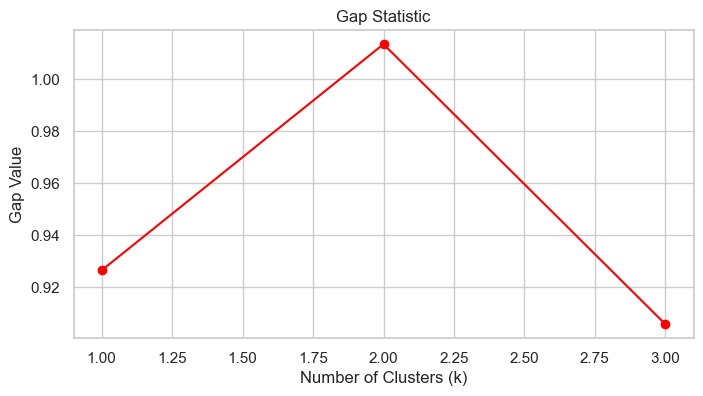

Gap Statistic Recommended k: 2


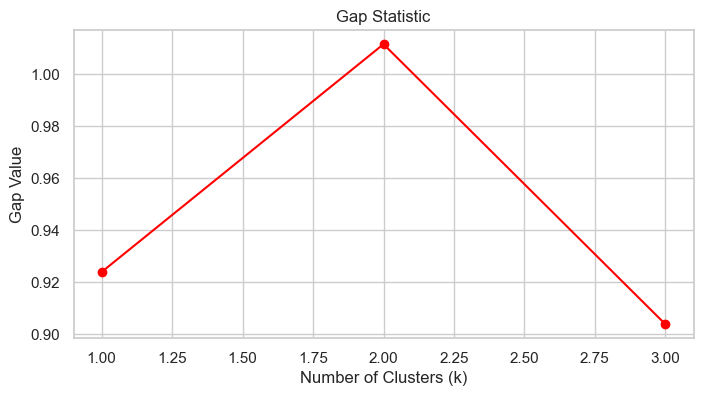

Gap Statistic Recommended k: 2
Standard K-means: Time=0.16s, Inertia=3492.0765802859974, Silhouette=0.4397, Gap Optimal K=2
MiniBatchKMeans: Time=0.06s, Inertia=3918.8979004904413, Silhouette=0.2585, Gap Optimal K=2


In [212]:
results = compare_mini_batch_kmeans(df_scaled, k=3, refs=20)

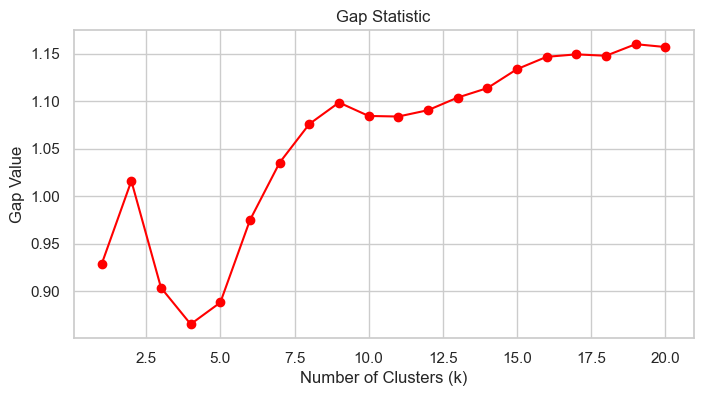

Gap Statistic Recommended k: 2


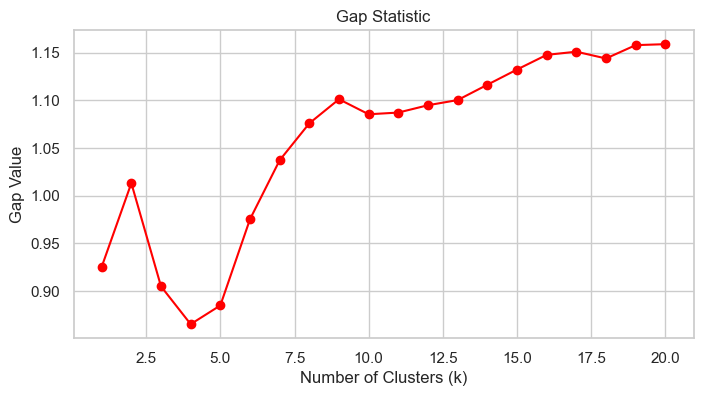

Gap Statistic Recommended k: 2
Standard K-means: Time=0.17s, Inertia=895.0388254628542, Silhouette=0.2934, Gap Optimal K=2
MiniBatchKMeans: Time=0.19s, Inertia=1253.6597332182412, Silhouette=0.2735, Gap Optimal K=2


In [206]:
results = compare_mini_batch_kmeans(df_scaled, k=20, refs=20)

In [209]:
km_labels, mbkm_labels, km_inertia, mbkm_inertia = compare_mini_batch_kmeans(df_scaled, k=3)

CPU times: total: 297 ms
Wall time: 175 ms
CPU times: total: 125 ms
Wall time: 86.7 ms
Standard K-means Inertia: 3492.0765802859974
MiniBatchKMeans Inertia: 3918.8979004904413


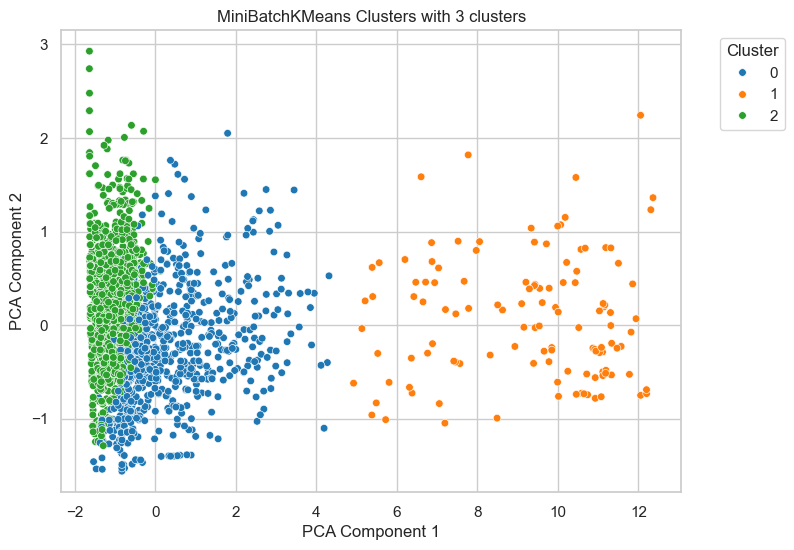

In [116]:
visualize_clusters_2d(df_scaled, mbkm_labels,title='MiniBatchKMeans Clusters with 3 clusters')


Now, we are introducing metrics under two main categories:  

Internal Metrics These are used to evaluate clustering quality without requiring a reference point. Examples include the silhouette score, Davies-Bouldin index, and within-cluster sum of squares (inertia). These metrics provide insights into how well-defined and distinct the clusters are internally.  

External Metrics These are used to compare the clustering results against a reference point or another clustering method, such as K-Means. Examples include adjusted Rand index, normalized mutual information, and Fowlkes-Mallows index. These metrics evaluate how well the clustering aligns with the reference or ground truth data.  

By using both internal and external metrics, we gain a more comprehensive understanding of clustering performance and its comparison with other methods.



Silhouette Score
Ranges from -1 to 1 (higher is better).


In [121]:
from sklearn.metrics import silhouette_score

def evaluate_silhouette(data, labels):
    score = silhouette_score(data, labels)
    print("Silhouette Score:", round(score, 3))
    return score


Calinski-Harabasz Index  balance between compactness and separation of clusters


In [122]:
from sklearn.metrics import calinski_harabasz_score

def evaluate_ch_index(data, labels):
    score = calinski_harabasz_score(data, labels)
    print("Calinski-Harabasz Index:", round(score, 3))
    return score


Davies-Bouldin Index  It considers both intra-cluster compactness and inter-cluster separation.


In [123]:
from sklearn.metrics import davies_bouldin_score

def evaluate_db_index(data, labels):
    score = davies_bouldin_score(data, labels)
    print("Davies-Bouldin Index:", round(score, 3))
    return score



External Metrics

Adjusted Rand Index (ARI)
Ranges from -1 to 1 (closer to 1 = more similarity). 
 similarity between two clustering results
 in here with K-Means.

In [127]:
from sklearn.metrics import adjusted_rand_score

def evaluate_ari(true_labels, pred_labels):
    ari = adjusted_rand_score(true_labels, pred_labels)
    print("Adjusted Rand Index:", round(ari, 3))
    return ari


Normalized Mutual Information (NMI)
Ranges from 0 to 1 (closer to 1 = more similarity)
It is similar in concept. The point is to compare clusters. Normalized Mutual Information (NMI) focuses more on the overlap between clusters rather than just pairwise matching. It measures the amount of shared information between the clustering assignments and a reference or ground truth, making it particularly useful for understanding how well clusters represent overlapping or ambiguous data points.

In [129]:
from sklearn.metrics import normalized_mutual_info_score

def evaluate_nmi(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    print("Normalized Mutual Information:", round(nmi, 3))
    return nmi


Homogeneity, Completeness, V-measure
Homogeneity: Each cluster contains only members of a single class.
Completeness: All members of a given class are assigned to the same cluster.
V-measure: Harmonic mean of homogeneity and completeness.

It reminds me of a confusion matrix.

In [131]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

def evaluate_hcv(true_labels, pred_labels):
    h = homogeneity_score(true_labels, pred_labels)
    c = completeness_score(true_labels, pred_labels)
    v = v_measure_score(true_labels, pred_labels)
    print("Homogeneity:", round(h, 3))
    print("Completeness:", round(c, 3))
    print("V-Measure:", round(v, 3))
    return h, c, v


A more robust approach involves handling K-Means hyperparameter tuning with side-by-side visualizations.

In [132]:


def hyperparameter_tuning_kmeans(data, cluster_range):

    results = {
        "inertia": [],
        "silhouette": [],
        "davies_bouldin": []
    }

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)

     
        inertia = kmeans.inertia_
        silhouette = evaluate_silhouette(data, labels)
        davies_bouldin = evaluate_db_index(data, labels)

     
        results["inertia"].append(inertia)
        results["silhouette"].append(silhouette)
        results["davies_bouldin"].append(davies_bouldin)

    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.plot(cluster_range, results["inertia"], marker="o")
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")


    plt.subplot(1, 3, 2)
    plt.plot(cluster_range, results["silhouette"], marker="o")
    plt.title("Silhouette Score")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")


    plt.subplot(1, 3, 3)
    plt.plot(cluster_range, results["davies_bouldin"], marker="o")
    plt.title("Davies-Bouldin Index")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Index")

    plt.tight_layout()
    plt.show()

    return results


Silhouette Score: 0.801
Davies-Bouldin Index: 0.348
Silhouette Score: 0.445
Davies-Bouldin Index: 0.808
Silhouette Score: 0.268
Davies-Bouldin Index: 1.149
Silhouette Score: 0.276
Davies-Bouldin Index: 1.106
Silhouette Score: 0.27
Davies-Bouldin Index: 1.112
Silhouette Score: 0.292
Davies-Bouldin Index: 1.017
Silhouette Score: 0.258
Davies-Bouldin Index: 1.161
Silhouette Score: 0.28
Davies-Bouldin Index: 1.082
Silhouette Score: 0.273
Davies-Bouldin Index: 1.113
Silhouette Score: 0.28
Davies-Bouldin Index: 1.068
Silhouette Score: 0.262
Davies-Bouldin Index: 1.113
Silhouette Score: 0.27
Davies-Bouldin Index: 1.14
Silhouette Score: 0.277
Davies-Bouldin Index: 1.098
Silhouette Score: 0.287
Davies-Bouldin Index: 1.092
Silhouette Score: 0.286
Davies-Bouldin Index: 1.105
Silhouette Score: 0.286
Davies-Bouldin Index: 1.138
Silhouette Score: 0.284
Davies-Bouldin Index: 1.143
Silhouette Score: 0.282
Davies-Bouldin Index: 1.105


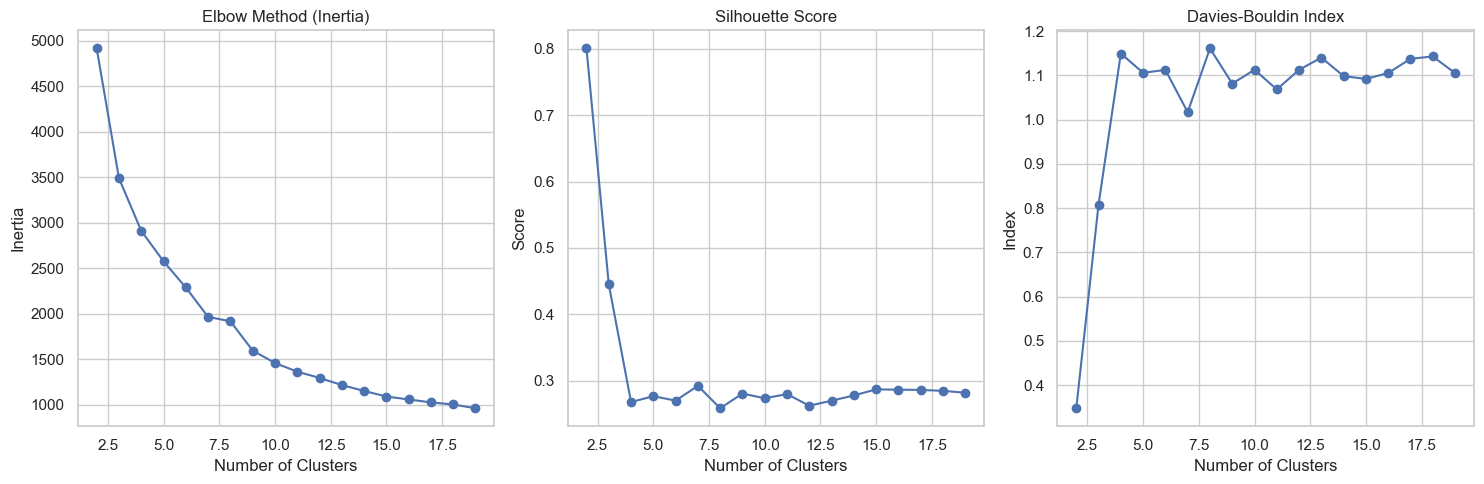

In [134]:
cluster_range = range(2, 20)
results = hyperparameter_tuning_kmeans(df_scaled, cluster_range)


Silhouette Score: 0.567
Davies-Bouldin Index: 0.775
Silhouette Score: 0.637
Davies-Bouldin Index: 0.524
Silhouette Score: 0.498
Davies-Bouldin Index: 0.703


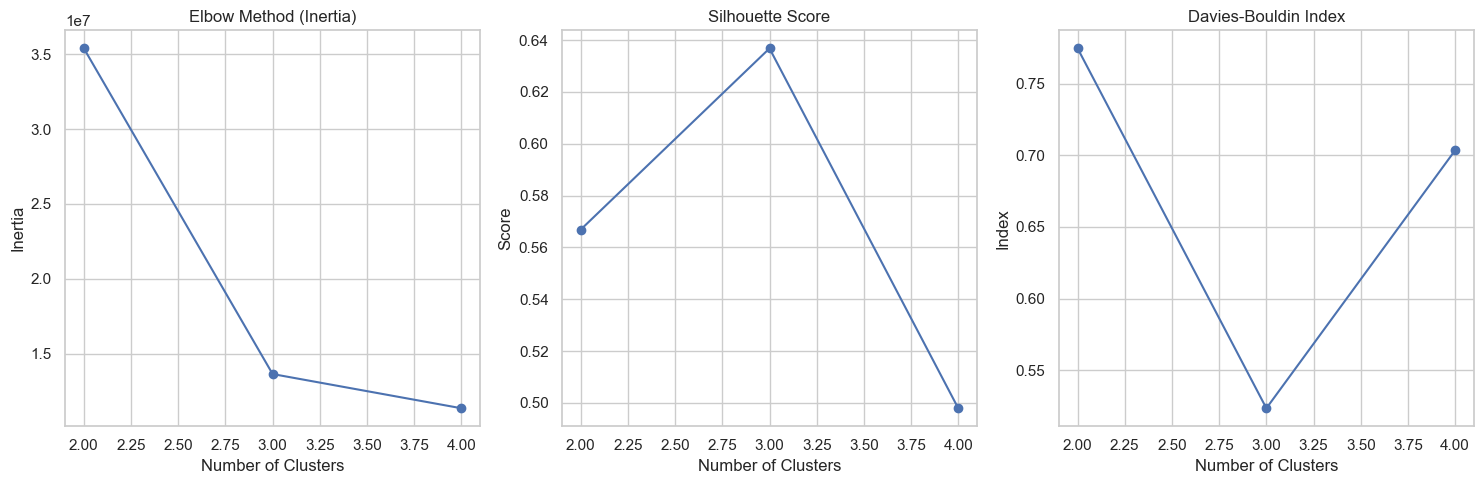

In [213]:
cluster_range = range(2, 5)
results = hyperparameter_tuning_kmeans(df, cluster_range)




Number of Clusters  
The Elbow method gives a range where the curve flattens, and the Gap statistic suggests a specific number by comparing within-cluster dispersion to a reference. If the Elbow method suggests around 10 and the Gap statistic points to 9 or 12, try both and decide based on context or validation metrics.  

K-Means with 15 Clusters  
After deciding on 15 clusters (either by requirement or analysis), I built the model and visualized it in 2D using PCA. This helped see how points group together. The goal is to check if the clusters make sense.  

Mini-Batch K-Means Comparison  
Mini-Batch K-Means is faster and works well for large datasets, but it’s slightly less accurate due to approximations (higher inertia). If the dataset is big, this method balances speed and quality. For smaller datasets, standard K-Means is better for more precise results.  

Summary  
Found the best cluster count using the Elbow and Gap methods.  
Built a K-Means model with 15 clusters.  
Visualized the clusters in 2D.  
Compared standard K-Means with Mini-Batch K-Means and noted differences in speed and results.  

HDBSCAN
Key Idea:
DBSCAN:Density-based clustering that groups closely packed points and marks sparse regions as noise.
A density-based clustering approach that handles variable density.
Automatically finds the number of clusters.
Key hyperparameters: min_cluster_size, min_samples.Hierarchical version of DBSCAN that adjusts for varying densities.
min_cluster_size:Clusters with fewer than this number of points will be considered noise.
min_samples:Controls the minimum number of points required to consider a data point as "core" for density estimation.

In [164]:

def tune_hdbscan(data, min_cluster_size_values, min_samples_values):

    results = []
    best_labels = None
    best_params = None
    best_score = -1  

    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:

            clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric='euclidean')
            labels = clusterer.fit_predict(data)
            

            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            num_noise = sum(labels == -1)
            

            if num_clusters > 1:
                score = silhouette_score(data, labels, metric='euclidean')
            else:
                score = -1  
            
  s
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'num_clusters': num_clusters,
                'num_noise_points': num_noise,
                'silhouette_score': score
            })
            
       
            if score > best_score:
                best_score = score
                best_labels = labels
                best_params = {
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples
                }

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='silhouette_score', ascending=False)

    return best_labels, best_params, results_df



In [165]:
min_cluster_size_values = [2, 4, 8, 16]
min_samples_values = [2, 4, 8, 16]


hdbscan_labels, best_params, results_df = tune_hdbscan(df_scaled, min_cluster_size_values, min_samples_values)
print("Best Parameters:", best_params)
print(results_df)


Best Parameters: {'min_cluster_size': 16, 'min_samples': 8}
    min_cluster_size  min_samples  num_clusters  num_noise_points  \
14                16            8             2                25   
3                  2           16             2                25   
11                 8           16             2                25   
15                16           16             2                25   
7                  4           16             3                55   
0                  2            2           626               366   
4                  4            2           236               527   
8                  8            2            90               630   
5                  4            4           127               808   
1                  2            4           194               861   
9                  8            4            67               764   
12                16            2            30               556   
13                16            4          

Gaussian Mixture Model (GMM)


Assumes data is generated from a mixture of Gaussian distributions.
Allows for soft clustering (probabilistic assignments).
Key hyperparameters: n_components (number of clusters), covariance_type (e.g., 'full', 'tied', 'diag', 'spherical').


n_components:number of clusters (analogous to K-Means’ k)
covariance_type: how each cluster’s covariance is estimated (less flexible → simpler model, more flexible → risk of overfitting).

'full': Each component has its own full covariance matrix (most flexible but computationally expensive).
'tied': All components share the same covariance matrix (less flexible, faster).
'diag': Each component has its own diagonal covariance matrix (only variances, no correlations; balances flexibility and speed).
'spherical': Each component has its own spherical covariance matrix (variance is shared across all dimensions; least flexible, fastest).

In [138]:


def run_gmm_with_gridsearch(data, param_grid):

    best_params = None
    best_score = -np.inf

  
    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(
            n_components=params['n_components'],
            covariance_type=params['covariance_type'],
            random_state=42
        )
        gmm.fit(data)
        score = gmm.score(data)  

        print(f"Params: {params}, Log-Likelihood Score: {score}")


        if score > best_score:
            best_score = score
            best_params = params

    print("\nBest Parameters:", best_params)
    print("Best Log-Likelihood Score:", best_score)

    best_gmm = GaussianMixture(
        n_components=best_params['n_components'],
        covariance_type=best_params['covariance_type'],
        random_state=42
    )
    best_gmm.fit(data)
    labels = best_gmm.predict(data)

    return {
        'best_params': best_params,
        'best_score': best_score,
        'labels': labels
    }


param_grid = {
    'n_components': [2, 3, 4, 5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}



In [139]:


param_grid = {
    'n_components': [2, 3, 4, 5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']
}

gmm_params = run_gmm_with_gridsearch(df_scaled, param_grid)
gmm_labels = gmm_params.get("labels")


Params: {'covariance_type': 'full', 'n_components': 2}, Log-Likelihood Score: -4.147414273662355
Params: {'covariance_type': 'full', 'n_components': 3}, Log-Likelihood Score: -4.022150822521106
Params: {'covariance_type': 'full', 'n_components': 4}, Log-Likelihood Score: -3.839810929120949
Params: {'covariance_type': 'full', 'n_components': 5}, Log-Likelihood Score: -3.398266072917652
Params: {'covariance_type': 'tied', 'n_components': 2}, Log-Likelihood Score: -4.412049019887906
Params: {'covariance_type': 'tied', 'n_components': 3}, Log-Likelihood Score: -4.273871418309321
Params: {'covariance_type': 'tied', 'n_components': 4}, Log-Likelihood Score: -4.21167938046057
Params: {'covariance_type': 'tied', 'n_components': 5}, Log-Likelihood Score: -4.151776330428924
Params: {'covariance_type': 'diag', 'n_components': 2}, Log-Likelihood Score: -4.200838593668071
Params: {'covariance_type': 'diag', 'n_components': 3}, Log-Likelihood Score: -4.075672192185788
Params: {'covariance_type': 'di

Mean-Shift

A non-parametric, iterative method that shifts data points towards higher density areas.
Number of clusters is determined by the algorithm.
Key hyperparameter: bandwidth (influence area around each point).

In [144]:

def run_meanshift(data, quantile, bin_seeding=True, cluster_all=True, min_bin_freq=1):

    bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=1000)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=bin_seeding, cluster_all=cluster_all, min_bin_freq=min_bin_freq)
    ms.fit(data)
    labels = ms.labels_
    print(f"Mean-Shift: Number of clusters found with quantile={quantile}, bin_seeding={bin_seeding}, cluster_all={cluster_all}, min_bin_freq={min_bin_freq}: {len(np.unique(labels))}")
    return labels, bandwidth

def grid_search_meanshift(data, quantile_values, bin_seeding_options, cluster_all_options, min_bin_freq_values):
 
    best_params = {}
    best_score = -1
    best_labels = None
    
    for quantile in quantile_values:
        for bin_seeding in bin_seeding_options:
            for cluster_all in cluster_all_options:
                for min_bin_freq in min_bin_freq_values:
                    try:
                        labels, _ = run_meanshift(data, quantile, bin_seeding, cluster_all, min_bin_freq)
                        # Calculate silhouette score (requires at least 2 clusters)
                        if len(np.unique(labels)) > 1:
                            score = silhouette_score(data, labels)
                            #print(f"Quantile={quantile}, Bin Seeding={bin_seeding}, Cluster All={cluster_all}, Min Bin Freq={min_bin_freq}, Silhouette Score={score}")
                            if score > best_score:
                                best_score = score
                                best_params = {
                                    "quantile": quantile,
                                    "bin_seeding": bin_seeding,
                                    "cluster_all": cluster_all,
                                    "min_bin_freq": min_bin_freq
                                }
                                best_labels = labels
                    except Exception as e:
                        print(f"Error for Quantile={quantile}, Bin Seeding={bin_seeding}, Cluster All={cluster_all}, Min Bin Freq={min_bin_freq}: {e}")
    
    print(f"Best Parameters: {best_params} with Silhouette Score={best_score}")
    return best_params, best_labels



In [145]:

quantile_values = np.linspace(0.05, 0.5, 10)  
bin_seeding_options = [True, False]
cluster_all_options = [True, False]
min_bin_freq_values = [1, 5, 10]

best_params, ms_labels = grid_search_meanshift(df_scaled, quantile_values, bin_seeding_options, cluster_all_options, min_bin_freq_values)


Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=True, min_bin_freq=1: 16
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=True, min_bin_freq=5: 5
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=True, min_bin_freq=10: 4
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=False, min_bin_freq=1: 17
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=False, min_bin_freq=5: 6
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=True, cluster_all=False, min_bin_freq=10: 5
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=False, cluster_all=True, min_bin_freq=1: 20
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=False, cluster_all=True, min_bin_freq=5: 20
Mean-Shift: Number of clusters found with quantile=0.05, bin_seeding=False, cluster_all=True, min_bin

Hierarchical Clustering


Builds a hierarchy of clusters via agglomerative or divisive methods.
Key hyperparameters: n_clusters, linkage (e.g., 'ward', 'complete', 'average').

In [146]:

def grid_search_hierarchical_clustering(data, cluster_range, linkage_options):
    """
    Perform grid search for Agglomerative Clustering using silhouette score.
    
    Parameters:
        data: Scaled dataset for clustering
        cluster_range: List of n_clusters to try
        linkage_options: List of linkage methods to try
    
    Returns:
        Best parameters, best silhouette score, and corresponding labels
    """
    best_score = -1
    best_params = {}
    best_labels = None
    
    for n_clusters in cluster_range:
        for linkage in linkage_options:
            hc = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='euclidean', 
                                         linkage=linkage)
            labels = hc.fit_predict(data)
         
            score = silhouette_score(data, labels)
            print(f"n_clusters={n_clusters}, linkage={linkage}, silhouette_score={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage}
                best_labels = labels  
    print(f"Best params: {best_params}, Best silhouette score: {best_score:.4f}")
    return best_params, best_score, best_labels



In [147]:
cluster_range = [2, 3, 4, 5, 6]
linkage_options = ['ward', 'complete', 'average', 'single']
best_params, best_score, hc_labels = grid_search_hierarchical_clustering(df_scaled, cluster_range, linkage_options)

n_clusters=2, linkage=ward, silhouette_score=0.7977
n_clusters=2, linkage=complete, silhouette_score=0.7183
n_clusters=2, linkage=average, silhouette_score=0.7977
n_clusters=2, linkage=single, silhouette_score=0.3949
n_clusters=3, linkage=ward, silhouette_score=0.4129
n_clusters=3, linkage=complete, silhouette_score=0.6314
n_clusters=3, linkage=average, silhouette_score=0.7167
n_clusters=3, linkage=single, silhouette_score=0.3772
n_clusters=4, linkage=ward, silhouette_score=0.4091
n_clusters=4, linkage=complete, silhouette_score=0.5231
n_clusters=4, linkage=average, silhouette_score=0.5050
n_clusters=4, linkage=single, silhouette_score=0.3690
n_clusters=5, linkage=ward, silhouette_score=0.2398
n_clusters=5, linkage=complete, silhouette_score=0.3084
n_clusters=5, linkage=average, silhouette_score=0.4932
n_clusters=5, linkage=single, silhouette_score=0.3689
n_clusters=6, linkage=ward, silhouette_score=0.2385
n_clusters=6, linkage=complete, silhouette_score=0.2486
n_clusters=6, linkage=av


linkage='ward' minimizes within-cluster variance (like K-Means).
'complete' or 'average' can help if clusters are not spherical.



HDBSCAN: Changing min_cluster_size and min_samples controls whether smaller clusters or more outliers show up.
GMM: Play with n_components and use BIC/AIC to find the best fit. Adjust covariance_type to let clusters have more or less flexible shapes.
Mean-Shift: The bandwidth decides how many clusters you get. Use estimate_bandwidth for an automatic approach based on the data.
Hierarchical: Adjust n_clusters or check the dendrogram to choose the cutoff point. linkage changes how distances between clusters are calculated.

In [148]:
chosen_k = 3  
kmeans_model = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)
labels = kmeans_model.labels_

print("K-means with", chosen_k, "clusters fitted.")



K-means with 3 clusters fitted.


In [160]:
kmeans_labels = labels

In here, we are starting the comparison, and next, we will visualize the results.

In [167]:

sil_score = evaluate_silhouette(df_scaled, hc_labels )
ch_score = evaluate_ch_index(df_scaled, hc_labels )
db_score = evaluate_db_index(df_scaled, hc_labels )

ari = evaluate_ari(kmeans_labels, hc_labels)
nmi = evaluate_nmi(kmeans_labels, hc_labels)
h, c, v = evaluate_hcv(kmeans_labels, hc_labels)

sil_score = evaluate_silhouette(df_scaled, ms_labels)
ch_score = evaluate_ch_index(df_scaled, ms_labels)
db_score = evaluate_db_index(df_scaled, ms_labels)

ari = evaluate_ari(kmeans_labels, ms_labels)
nmi = evaluate_nmi(kmeans_labels, ms_labels)
h, c, v = evaluate_hcv(kmeans_labels, ms_labels)


sil_score = evaluate_silhouette(df_scaled, gmm_labels )
ch_score = evaluate_ch_index(df_scaled, gmm_labels )
db_score = evaluate_db_index(df_scaled, gmm_labels )

ari = evaluate_ari(kmeans_labels, gmm_labels )
nmi = evaluate_nmi(kmeans_labels, gmm_labels )
h, c, v = evaluate_hcv(kmeans_labels, gmm_labels )




sil_score = evaluate_silhouette(df_scaled, hdbscan_labels )
ch_score = evaluate_ch_index(df_scaled, hdbscan_labels )
db_score = evaluate_db_index(df_scaled, hdbscan_labels )

ari = evaluate_ari(kmeans_labels, hdbscan_labels )
nmi = evaluate_nmi(kmeans_labels, hdbscan_labels )
h, c, v = evaluate_hcv(kmeans_labels, hdbscan_labels )



sil_score = evaluate_silhouette(df_scaled, kmeans_labels)
ch_score = evaluate_ch_index(df_scaled, kmeans_labels)
db_score = evaluate_db_index(df_scaled, kmeans_labels)









Silhouette Score: 0.798
Calinski-Harabasz Index: 4779.436
Davies-Bouldin Index: 0.366
Adjusted Rand Index: 0.392
Normalized Mutual Information: 0.473
Homogeneity: 0.323
Completeness: 0.887
V-Measure: 0.473
Silhouette Score: 0.801
Calinski-Harabasz Index: 4800.274
Davies-Bouldin Index: 0.348
Adjusted Rand Index: 0.383
Normalized Mutual Information: 0.479
Homogeneity: 0.324
Completeness: 0.913
V-Measure: 0.479
Silhouette Score: 0.218
Calinski-Harabasz Index: 1982.806
Davies-Bouldin Index: 1.42
Adjusted Rand Index: 0.128
Normalized Mutual Information: 0.312
Homogeneity: 0.543
Completeness: 0.219
V-Measure: 0.312
Silhouette Score: 0.721
Calinski-Harabasz Index: 2354.721
Davies-Bouldin Index: 1.038
Adjusted Rand Index: 0.377
Normalized Mutual Information: 0.466
Homogeneity: 0.326
Completeness: 0.815
V-Measure: 0.466
Silhouette Score: 0.455
Calinski-Harabasz Index: 3825.073
Davies-Bouldin Index: 0.793


Silhouette Score: 0.798
Calinski-Harabasz Index: 4779.436
Davies-Bouldin Index: 0.366
Adjusted Rand Index: 0.392
Normalized Mutual Information: 0.473
Homogeneity: 0.323
Completeness: 0.887
V-Measure: 0.473
Adjusted Rand Index: 0.392
Normalized Mutual Information: 0.473
Homogeneity: 0.323
Completeness: 0.887
V-Measure: 0.473
Silhouette Score: 0.801
Calinski-Harabasz Index: 4800.274
Davies-Bouldin Index: 0.348
Adjusted Rand Index: 0.383
Normalized Mutual Information: 0.479
Homogeneity: 0.324
Completeness: 0.913
V-Measure: 0.479
Adjusted Rand Index: 0.383
Normalized Mutual Information: 0.479
Homogeneity: 0.324
Completeness: 0.913
V-Measure: 0.479
Silhouette Score: 0.218
Calinski-Harabasz Index: 1982.806
Davies-Bouldin Index: 1.42
Adjusted Rand Index: 0.128
Normalized Mutual Information: 0.312
Homogeneity: 0.543
Completeness: 0.219
V-Measure: 0.312
Adjusted Rand Index: 0.128
Normalized Mutual Information: 0.312
Homogeneity: 0.543
Completeness: 0.219
V-Measure: 0.312
Silhouette Score: 0.721

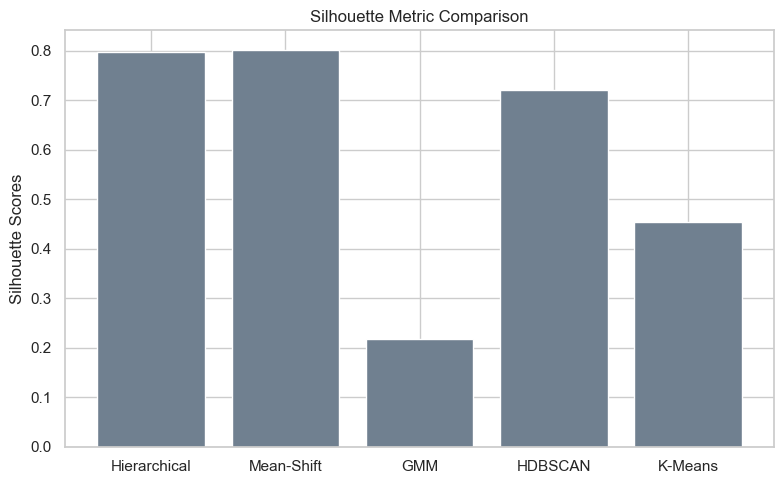

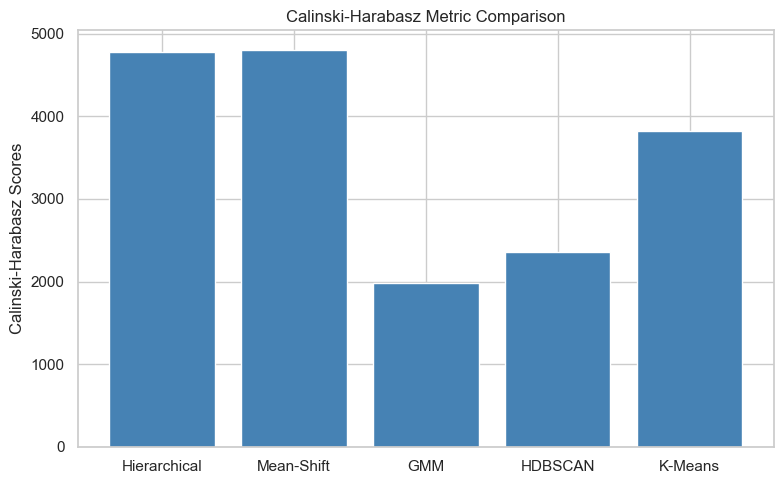

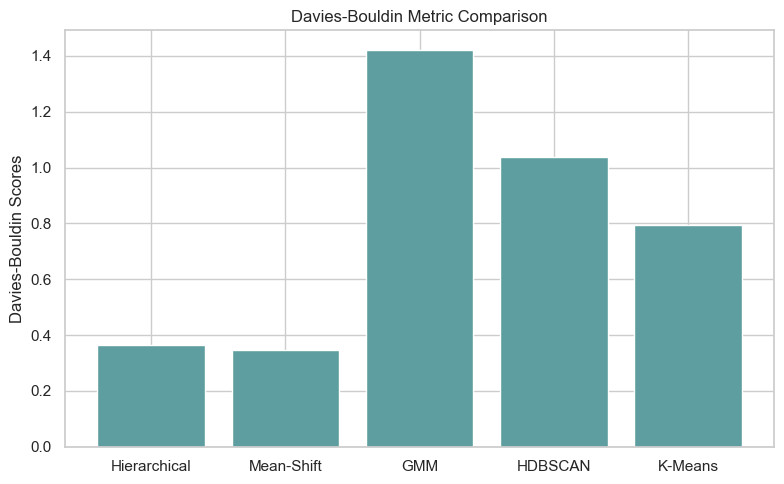

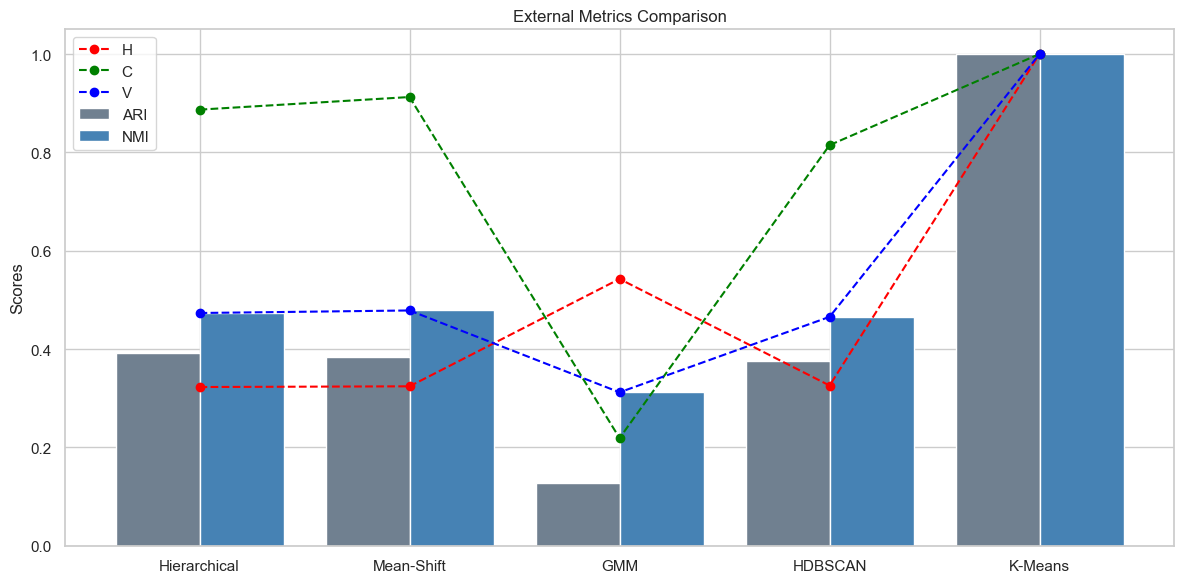

In [168]:


def get_internal_metrics(labels):
    sil_score = evaluate_silhouette(df_scaled, labels)
    ch_score = evaluate_ch_index(df_scaled, labels)
    db_score = evaluate_db_index(df_scaled, labels)
    return sil_score, ch_score, db_score

def get_external_metrics(reference_labels, labels):
    ari = evaluate_ari(reference_labels, labels)
    nmi = evaluate_nmi(reference_labels, labels)
    h, c, v = evaluate_hcv(reference_labels, labels)
    return ari, nmi, (h, c, v)


algorithms = ["Hierarchical", "Mean-Shift", "GMM", "HDBSCAN", "K-Means"]
labels_list = [hc_labels, ms_labels, gmm_labels, hdbscan_labels, kmeans_labels]

internal_metrics = []
external_metrics = []
hcv_scores = []

for labels in labels_list:
    internal_metrics.append(get_internal_metrics(labels))
    external, hcv = get_external_metrics(kmeans_labels, labels)[:2], get_external_metrics(kmeans_labels, labels)[2]
    external_metrics.append(external)
    hcv_scores.append(hcv)


silhouette_scores, ch_scores, db_scores = zip(*internal_metrics)
ari_scores, nmi_scores = zip(*external_metrics)
h_scores, c_scores, v_scores = zip(*hcv_scores)

plt.figure(figsize=(8, 5))
x = np.arange(len(algorithms))
plt.bar(x, silhouette_scores, color="slategray")
plt.xticks(x, algorithms)
plt.ylabel("Silhouette Scores")
plt.title("Silhouette Metric Comparison")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.bar(x, ch_scores, color="steelblue")
plt.xticks(x, algorithms)
plt.ylabel("Calinski-Harabasz Scores")
plt.title("Calinski-Harabasz Metric Comparison")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.bar(x, db_scores, color="cadetblue")
plt.xticks(x, algorithms)
plt.ylabel("Davies-Bouldin Scores")
plt.title("Davies-Bouldin Metric Comparison")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, ari_scores, width=0.4, label="ARI", color="slategray")
plt.bar(x + 0.2, nmi_scores, width=0.4, label="NMI", color="steelblue")


plt.plot(x, h_scores, label="H", marker="o", linestyle="--", color="red")
plt.plot(x, c_scores, label="C", marker="o", linestyle="--", color="green")
plt.plot(x, v_scores, label="V", marker="o", linestyle="--", color="blue")

plt.xticks(x, algorithms)
plt.ylabel("Scores")
plt.title("External Metrics Comparison")
plt.legend()
plt.tight_layout()
plt.show()




After trying all the models, I prefer the Mean-Shift model for this task. If you have a small dataset like this, it works well without spending too much time tuning hyperparameters. It's a bit compute-intensive, but that’s not an issue with small datasets.  

If I need to consider dataset constraints, I’d go with HDBSCAN or K-Means. I like HDBSCAN because it doesn’t require explicitly defining the number of clusters and still performs well due to its nature. On the other hand, K-Means is simple, effective, and works great for many tasks.


In [176]:
df['ms_labels'] = ms_labels

Now, let’s visualize our clusters on the world map to better understand their geographic distribution.

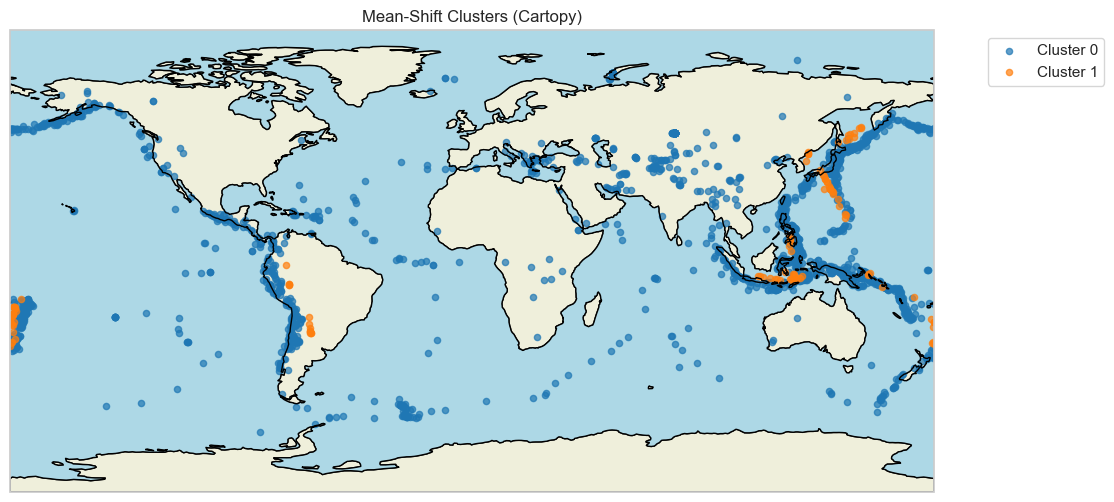

In [191]:

def plot_clusters_with_cartopy(df, lat_col='Latitude', lon_col='Longitude', label_col='MeanShift_Cluster'):


    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

  
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.set_title("Mean-Shift Clusters (Cartopy)")


    unique_labels = np.unique(df[label_col])
    palette = sns.color_palette('tab10', len(unique_labels))


    for idx, cluster_val in enumerate(unique_labels):
        subset = df[df[label_col] == cluster_val]
        ax.scatter(
            subset[lon_col], 
            subset[lat_col], 
            s=20, 
            color=palette[idx % len(palette)], 
            label=f"Cluster {cluster_val}",
            transform=ccrs.PlateCarree(), 
            alpha=0.7
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()


plot_clusters_with_cartopy(df, lat_col='Latitude', lon_col='Longitude', label_col='ms_labels')
